# Deep mutational scanning of Perth/2009 (H3N2) HA

Analysis and experiments done by Juhye Lee in the Bloom lab.

This is analysis of the sequencing data from a deep mutational scan of HA from the A/Perth/16/2009(H3N2) strain. I will be using `dms_tools2` to analyze the sequencing data. I created triplicate codon-mutant libraries of the Perth/2009 HA, rescued virus libraries using the helper virus approach described in [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155), and passaged the generated mutant virus libraries at low MOI in cell culture to select for functional variants of HA.

There are two samples for each library:

1. **Plasmidlib**: plasmids encoding the mutant library
2. **mutvirus**: cDNA from the mutant viruses after passaging.
 * One of the libraries (library 3) was passaged in technical replicate for samples 3-1 and 3-2.

There is also a set of controls:

1. **WTplasmid**: plasmid encoding wildtype HA

2. **WTvirus**: virus grown from the wildtype virus and passaged just like the libraries.


## Import modules, define directories

In [24]:
import os
import subprocess
import glob
import pandas as pd
import dms_tools2
import dms_tools2.plot
import dms_tools2.dssp
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore') # don't print warnings to avoid clutter in notebook
from IPython.display import display, HTML, Markdown
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Polygon
from matplotlib import gridspec
import scipy.stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pymodules.utils import * # custom modules for this analysis

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

fastqdir = './fastq/'
resultsdir = './results/'
countsdir = os.path.join(resultsdir, 'codoncounts')
prefsdir = os.path.join(resultsdir, 'preferences/')
corrdir = os.path.join(resultsdir, 'correlations')
plotsdir = os.path.join(resultsdir, 'plots/')
logodir = os.path.join(resultsdir, 'logoplots')
inputdir = './inputs/'

Using dms_tools2 version 2.1.0


## Get FASTQ files
Symbolically link to the files on the server.

In [2]:
log = !python ./scripts/symlink_fastq.py
print("Symbolically linked FASTQ files to {0}".format(fastqdir))

Symbolically linked FASTQ files to ./fastq/


## Define the samples

I will create a `pandas` dataframe to define the samples with its corresponding sample name. I will also create a dummy column.

In [3]:
samples = pandas.DataFrame([('WTplasmid', 'WTplasmid_R1_*.fastq.gz')] + 
                           [('WTvirus', 'WTvirus_R1_*.fastq.gz')] + 
                           [('Plasmidlib{0}'.format(n), 
                             'Plasmidlib{0}_R1_*.fastq.gz'.format(n)) for n in range (1,4)] + 
                           [('mutvirus{0}'.format(n), 
                             'mutvirus{0}_R1_*.fastq.gz'.format(n)) for n in range(1,3)] + 
                           [('mutvirus3-{0}'.format(n), 
                             'mutvirus3-{0}_R1_*.fastq.gz'.format(n)) for n in range (1,3)], 
                           columns = ['name', 'R1'])

display(HTML(samples.to_html(index=False)))

name,R1
WTplasmid,WTplasmid_R1_*.fastq.gz
WTvirus,WTvirus_R1_*.fastq.gz
Plasmidlib1,Plasmidlib1_R1_*.fastq.gz
Plasmidlib2,Plasmidlib2_R1_*.fastq.gz
Plasmidlib3,Plasmidlib3_R1_*.fastq.gz
mutvirus1,mutvirus1_R1_*.fastq.gz
mutvirus2,mutvirus2_R1_*.fastq.gz
mutvirus3-1,mutvirus3-1_R1_*.fastq.gz
mutvirus3-2,mutvirus3-2_R1_*.fastq.gz


## Align deep sequencing data and count mutations

In [4]:
# Reference coding sequence of Perth/2009 HA; from plasmid #1535 pICR2-Perth09-HA
refseq = 'Perth09_HA_reference.fa'

# Temporary align specs
alignspecs = ' '.join(['1,285,38,40', '286,567,33,34', '568,852,34,30', 
                       '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44'])

# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 --R2trim 161 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

print('Completed dms2_batch_bcsubamp.')


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


In [5]:
!ls {countsdir}/*_codoncounts.csv

./results/codoncounts/mutvirus1_codoncounts.csv
./results/codoncounts/mutvirus2_codoncounts.csv
./results/codoncounts/mutvirus3-1_codoncounts.csv
./results/codoncounts/mutvirus3-2_codoncounts.csv
./results/codoncounts/Plasmidlib1_codoncounts.csv
./results/codoncounts/Plasmidlib2_codoncounts.csv
./results/codoncounts/Plasmidlib3_codoncounts.csv
./results/codoncounts/WTplasmid_codoncounts.csv
./results/codoncounts/WTvirus_codoncounts.csv


In [6]:
countsplotprefix = os.path.join(countsdir, 'summary')

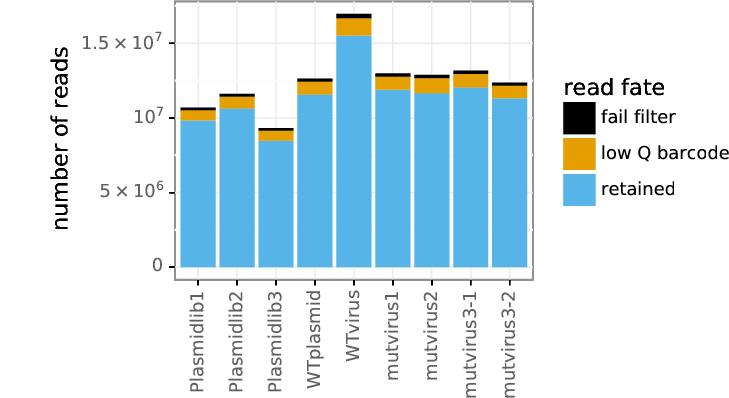

In [7]:
showPDF(countsplotprefix + '_readstats.pdf', width=500)

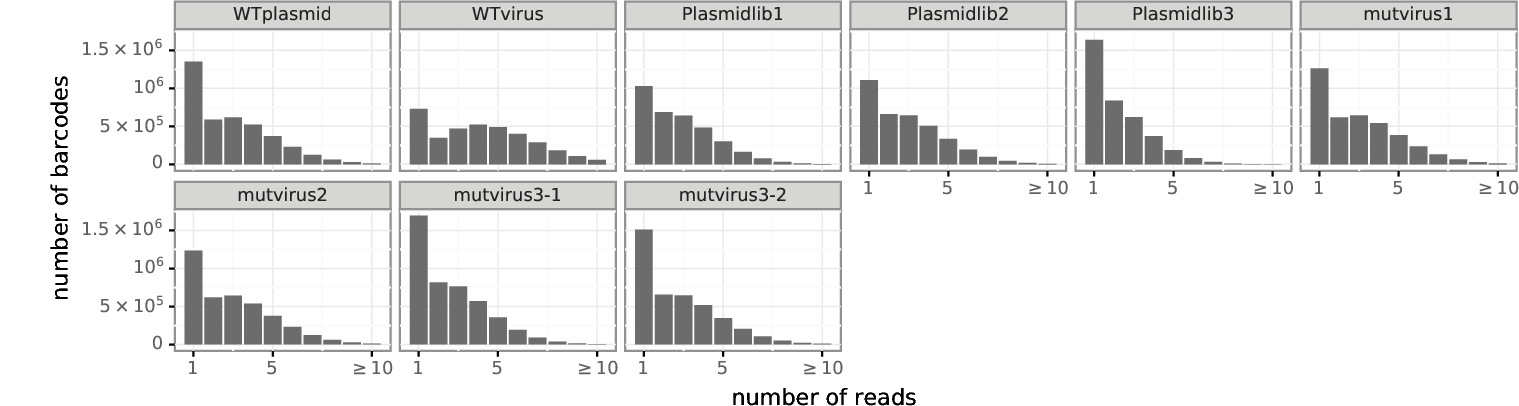

In [8]:
showPDF(countsplotprefix + '_readsperbc.pdf')

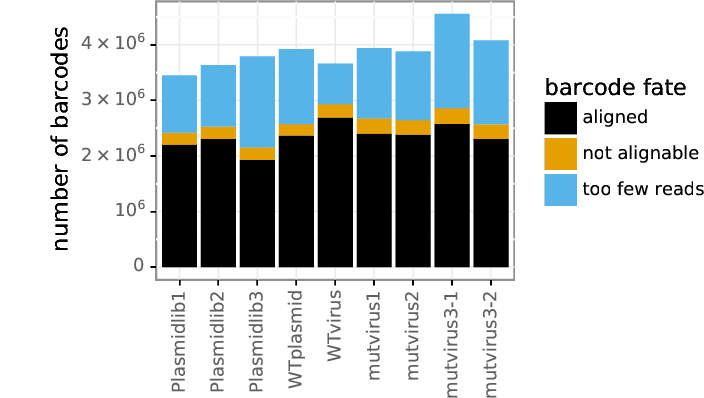

In [9]:
showPDF(countsplotprefix + '_bcstats.pdf', width=500)

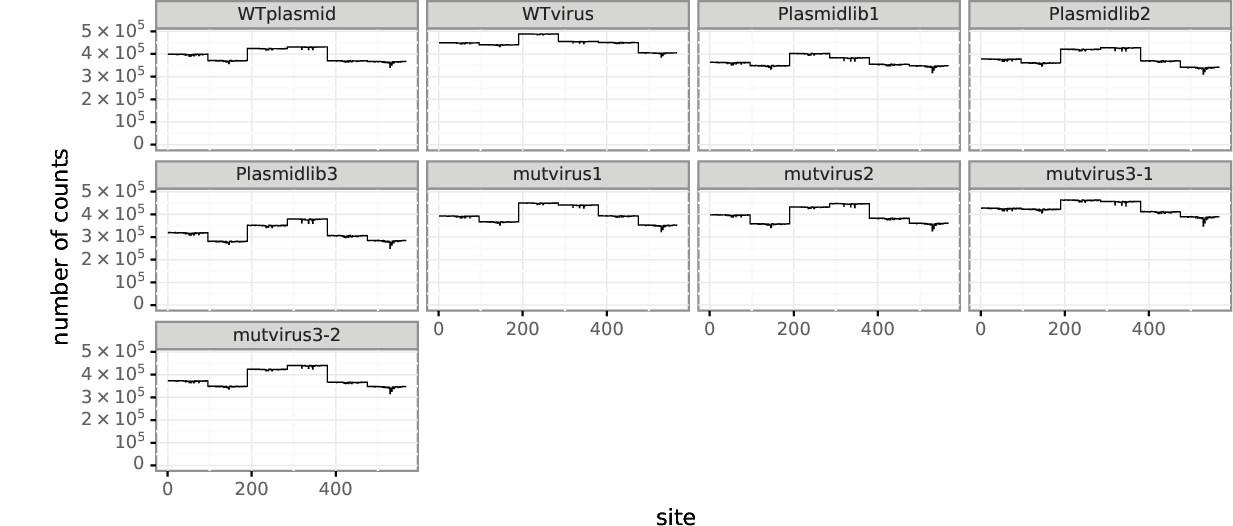

In [10]:
showPDF(countsplotprefix + '_depth.pdf')

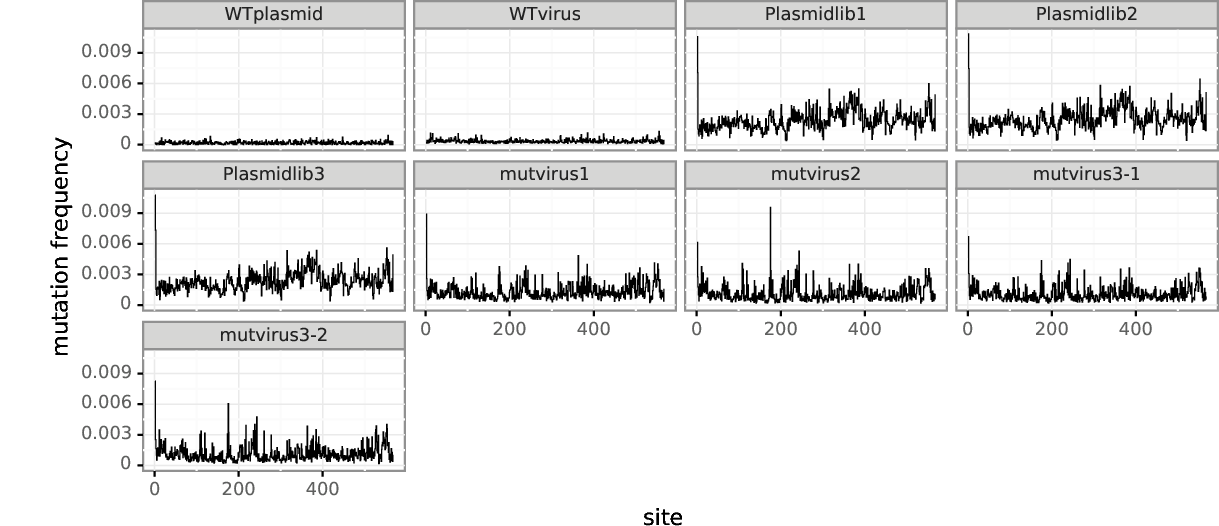

In [11]:
showPDF(countsplotprefix + '_mutfreq.pdf')

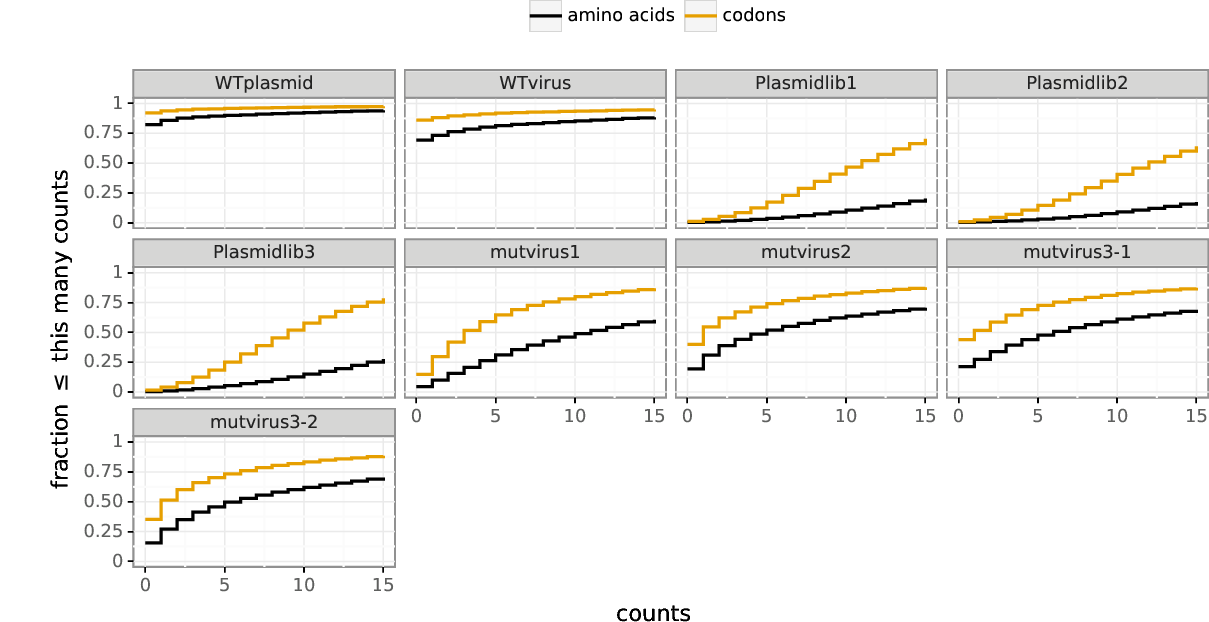

In [12]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

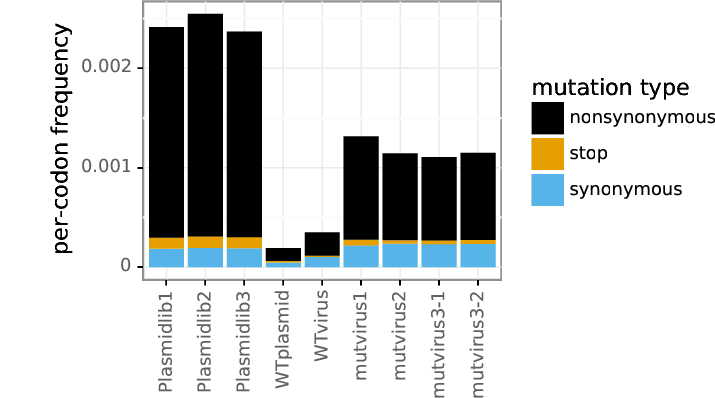

In [13]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=500)

In [14]:
codonmuttypes = pandas.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
Plasmidlib1,0.002118,0.000112,0.000186
Plasmidlib2,0.002237,0.000117,0.000193
Plasmidlib3,0.002068,0.000112,0.000191
WTplasmid,0.000130,0.000015,0.000047
WTvirus,0.000233,0.000015,0.000102
mutvirus1,0.001039,0.000059,0.000219
mutvirus2,0.000875,0.000036,0.000235
mutvirus3-1,0.000838,0.000039,0.000232
mutvirus3-2,0.000876,0.000040,0.000235


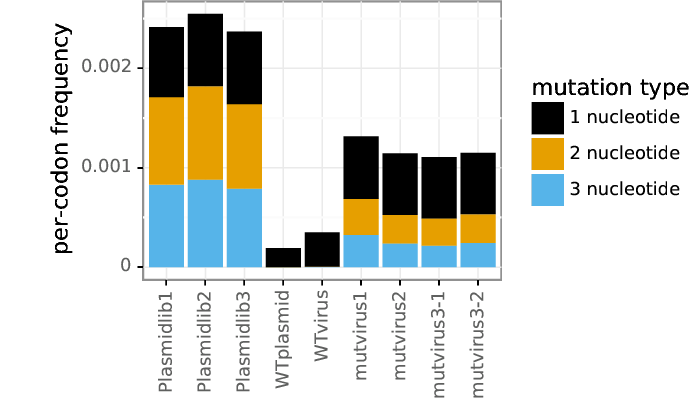

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=500)

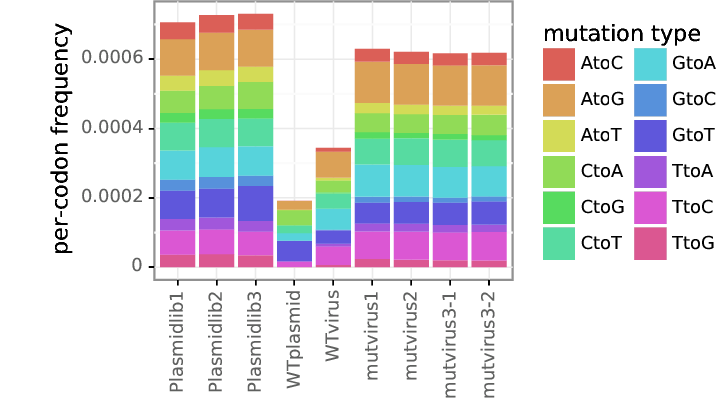

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=500)

# Infer the site-specific amino-acid preferences

In [7]:
# create batch file for dms2_batch_prefs
prefsbatch = pandas.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('replicate-1', 'Plasmidlib1', 'mutvirus1', 'WTplasmid', 'WTvirus'),
              ('replicate-2', 'Plasmidlib2', 'mutvirus2', 'WTplasmid', 'WTvirus'),
              ('replicate-3-1', 'Plasmidlib3', 'mutvirus3-1', 'WTplasmid', 'WTvirus'), 
              ('replicate-3-2', 'Plasmidlib3', 'mutvirus3-2', 'WTplasmid', 'WTvirus')]
        )
prefsbatchfile = os.path.join(prefsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)

print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing} 
print("Completed running dms2_batch_prefs")

Here is the batch file that we write to CSV format to use as input:


name,pre,post,errpre,errpost
replicate-1,Plasmidlib1,mutvirus1,WTplasmid,WTvirus
replicate-2,Plasmidlib2,mutvirus2,WTplasmid,WTvirus
replicate-3-1,Plasmidlib3,mutvirus3-1,WTplasmid,WTvirus
replicate-3-2,Plasmidlib3,mutvirus3-2,WTplasmid,WTvirus


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


In [8]:
!ls {prefsdir}/*_prefs.csv

./results/preferences//replicate-1_prefs.csv
./results/preferences//replicate-2_prefs.csv
./results/preferences//replicate-3-1_prefs.csv
./results/preferences//replicate-3-2_prefs.csv


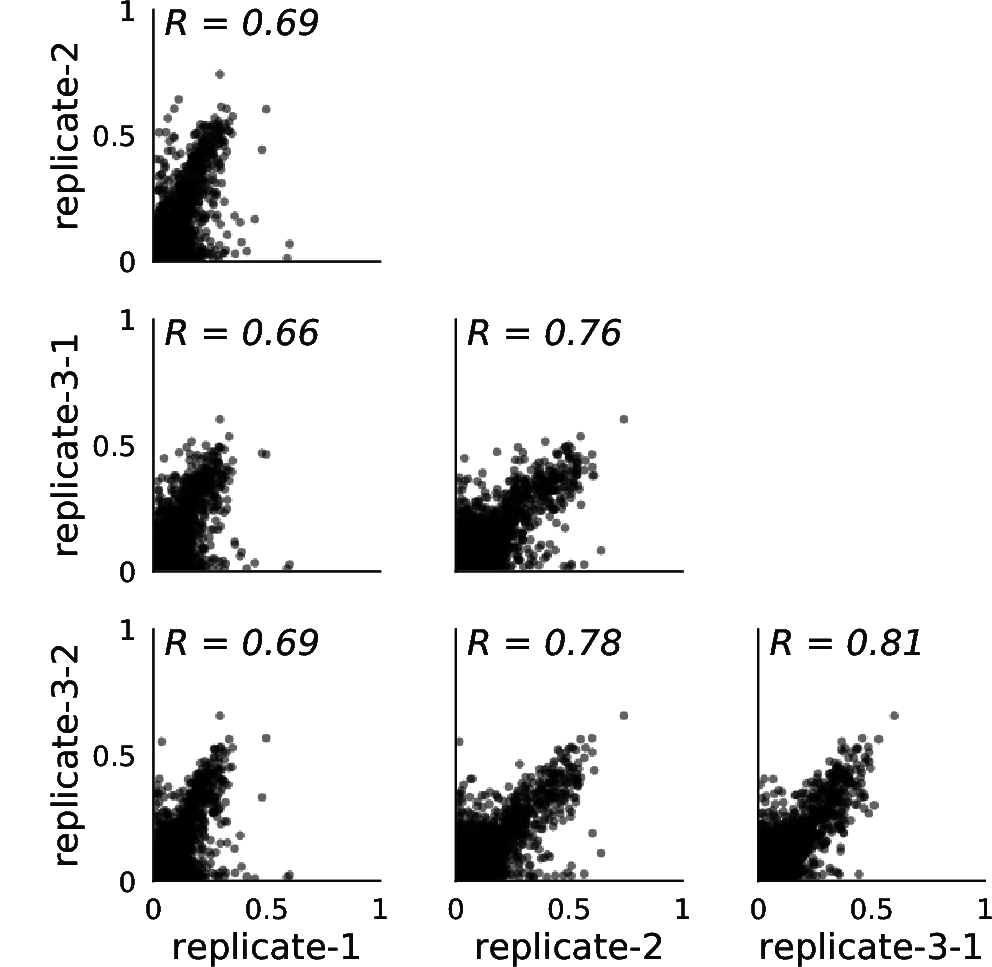

In [19]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'), width=300)

In [9]:
avgprefs = os.path.join(prefsdir, 'summary_avgprefs.csv')

# Display preferences in a logoplot

In [10]:
dsspfile = './inputs/4O5N_trimer.dssp'

# Need to read in chain A (HA1) and chain B (HA2) separately, then concatenate into a single dataframe
HA1dssp_df = dms_tools2.dssp.processDSSP(dsspfile, chain='A')
HA1sites = [x + 16 for x in HA1dssp_df['site'].tolist()]
HA1dssp_df['site'] = HA1sites

HA2dssp_df = dms_tools2.dssp.processDSSP(dsspfile, chain='B')
HA2sites = [x + 345 for x in HA2dssp_df['site'].tolist()]
HA2dssp_df['site'] = HA2sites

dssp_df = pd.concat([HA1dssp_df, HA2dssp_df])
dssp_df['SS'] = dssp_df['SS_class']
ssfile = os.path.join(prefsdir, 'SS.csv')
dssp_df[['site', 'SS']].to_csv(ssfile, index=False)
rsafile = os.path.join(prefsdir, 'RSA.csv')
dssp_df[['site', 'RSA']].to_csv(rsafile, index=False)

In [11]:
wtoverlayfile = os.path.join(prefsdir, 'wildtypeoverlayfile.csv')
aacounts = dms_tools2.utils.codonToAACounts(
        pandas.read_csv(os.path.join(countsdir, 'WTplasmid_codoncounts.csv')))
aacounts.query('wildtype != "*"')[['site', 'wildtype']].to_csv(wtoverlayfile, index=False)

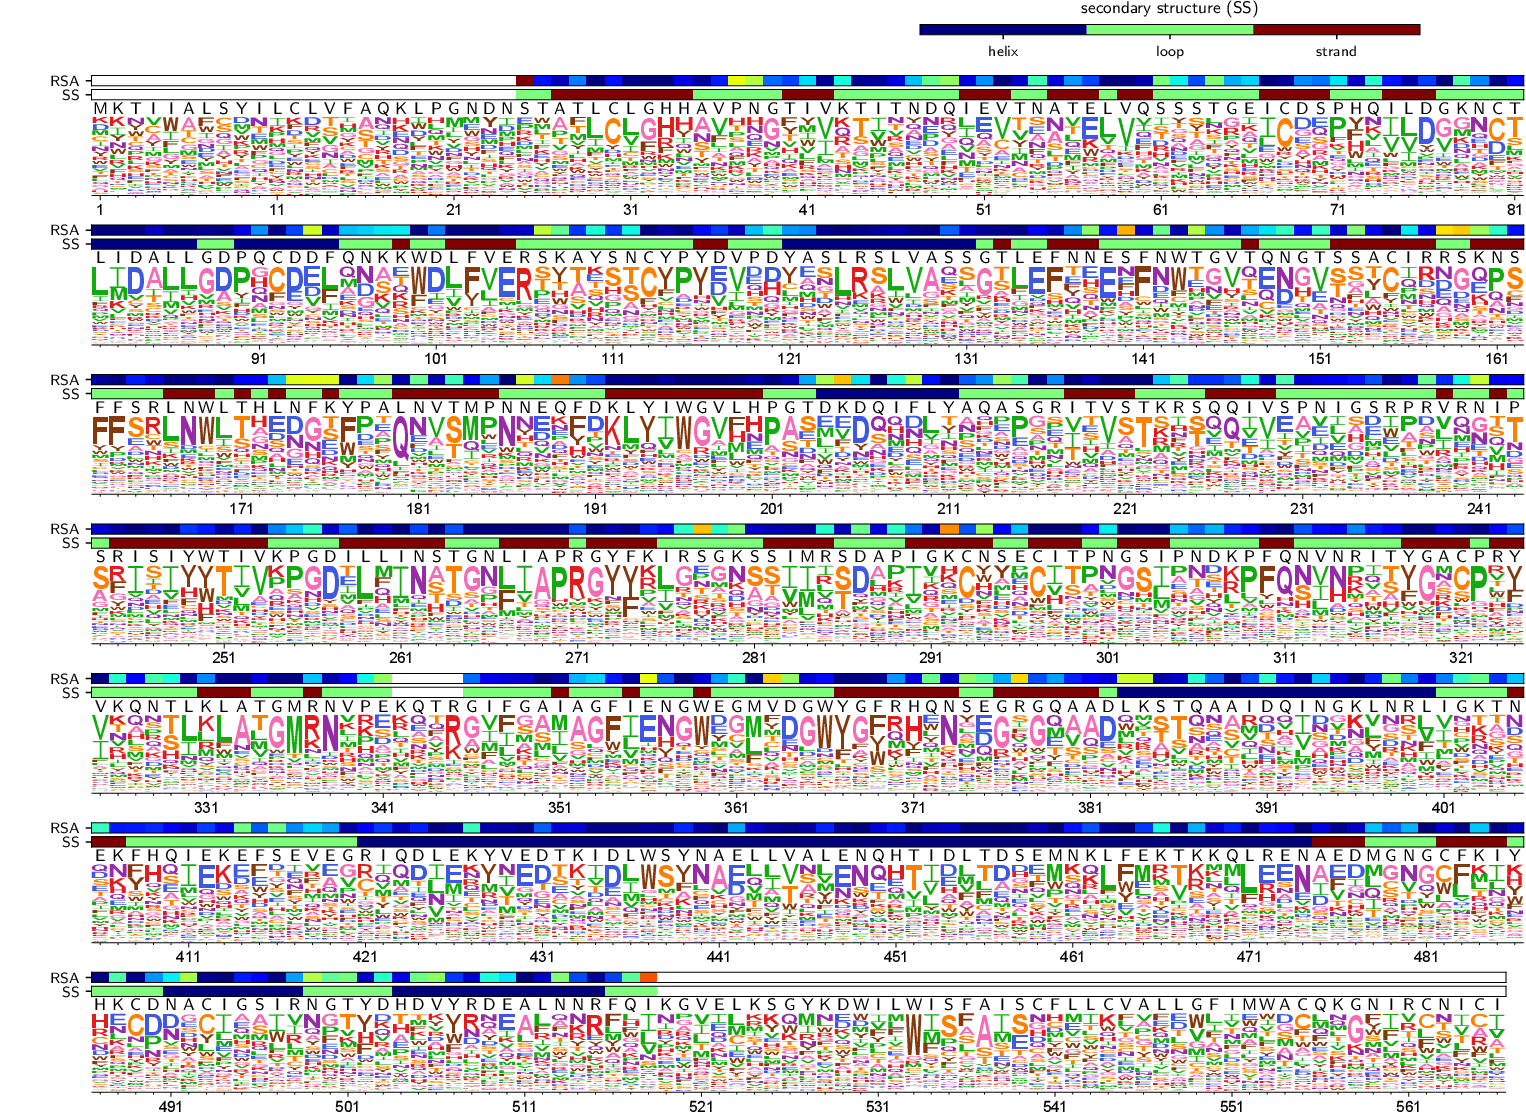

In [12]:
logoname = 'avgprefs'

log = !dms2_logoplot \
        --prefs {avgprefs} \
        --name {logoname} \
        --outdir {logodir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {ssfile} SS "secondary structure" \
        --overlay3 {rsafile} RSA "relative solvent accessibility" \
        --nperline 81 \
        --use_existing {use_existing}
        
logoplot = os.path.join(logodir, '{0}_prefs.pdf'.format(logoname))
showPDF(logoplot)

# See how well the site-specific amino acid preferences inferred above describe natural sequence evolution of human H3 HA using `phydms`

## Prepare input H3 fasta files using `phydms_prepalignment`

I downloaded the `H3_human.fa` file from Sarah Hilton's original `H3_phydms` analysis, and she downloaded all full-length, protein-coding human H3 sequences from the Influenza Virus Resource Database on 20170110.

In [13]:
print("Using the following version of phydms:")
!phydms -v

IVRfile = 'H3_human.fa'
Perth09file = 'Perth09_HA_reference.fa'
Perth09header = 'Reference_Perth2009_HA_coding_sequence'

Using the following version of phydms:
phydms 2.1.3


First I add the Perth/2009 HA reference sequence (`Perth09_HA_reference.fa`) to the IVR H3 sequences file (`H3_human.fa`) to form the `H3_human_ref.fa` output file.

In [14]:
infile1 = '{0}/{1}'.format(inputdir, IVRfile)
infile2 = './{0}'.format(Perth09file)
output_file = '{0}/H3_human_ref.fa'.format(inputdir)

if os.path.isfile(output_file):
    print('Perth/2009 HA reference sequence already added to H3 sequences FASTA file.')
else:
    os.system('cat {0} {1} > {2}'.format(infile1, infile2, output_file))

Perth/2009 HA reference sequence already added to H3 sequences FASTA file.


Next, I align and filter the IVR H3 sequences to the Perth/2009 HA sequence using `phydms_prepalignment`. This will output aligned sequences in the **`H3_alignment.fa`** file.

In [15]:
IVRalignment = '{0}/H3_alignment.fa'.format(inputdir)

if os.path.isfile(IVRalignment):
    print('H3 IVR sequences have already been prepped by phydms_prepalignment.')
else:
    subprocess.check_call(['phydms_prepalignment', '{0}/H3_human_ref.fa'.format(inputdir), 
                           IVRalignment, Perth09header])

H3 IVR sequences have already been prepped by phydms_prepalignment.


I will also average across replicates 2 and 3-1 and 3-2 to see if this average improves phylogenetic fit, since replicate 1 showed the least amount of selection and purging of stop codons.

## Subsample the aligned and filtered human H3 sequences using a subsampling script

I will subsample the aligned and filtered H3 sequences in `H3_alignment.fa`, using at most **1 sequence per year**. I will create 3 independent alignments.

The `subsample_IVR_sequences.py` script was written by Sarah Hilton specifically for H3 sequences. Three arguments need to be provided:
1. **IVRseqs**: the IVR alignment file (`H3_alignment.fa`)
2. **alignmentNumber**: the total number of final alignments (3)
3. **outPrefix**: the prefix for created alignment files (`H3_subsample`)

I will now subsample the aligned and filtered H3 sequences in `H3_alignment.fa`, using at most **2 sequences per year**. For years with only one sequence (_i.e.,_ 1970), that single sequence will be added to all subsamples. I will create 3 independent alignments.

The script I will use is `subsample_TwoPerYear.py`, which I modified from Sarah's `subsample_IVR_sequences.py` script.
These output files will be named with the prefix `H3_TwoPerYear_`.

In [17]:
subsample_TwoPerYear_outPrefix = '{0}/H3_TwoPerYear'.format(inputdir)

for sample in [1, 2, 3]:
    if os.path.isfile('{0}_{1}.fa'.format(subsample_TwoPerYear_outPrefix, sample)):
        print ('Subsampled alignment #{0} already exists'.format(sample))
    else:
        os.system('python scripts/subsample_TwoPerYear.py {0} 3 {1}'.format(IVRalignment, subsample_TwoPerYear_outPrefix))

Subsampled alignment #1 already exists
Subsampled alignment #2 already exists
Subsampled alignment #3 already exists


### Show phylogenetic trees of each of the subsampled sequences
I used the RAxML tree newick files of the subsampled H3 sequences from human and swine hosts to visualize the phylogenetic trees in FigTree, and saved the trees as PDFs. These trees are shown below.

Here are the RAxML trees for subsampled H3 HA from human hosts:

human subsample #1 tree


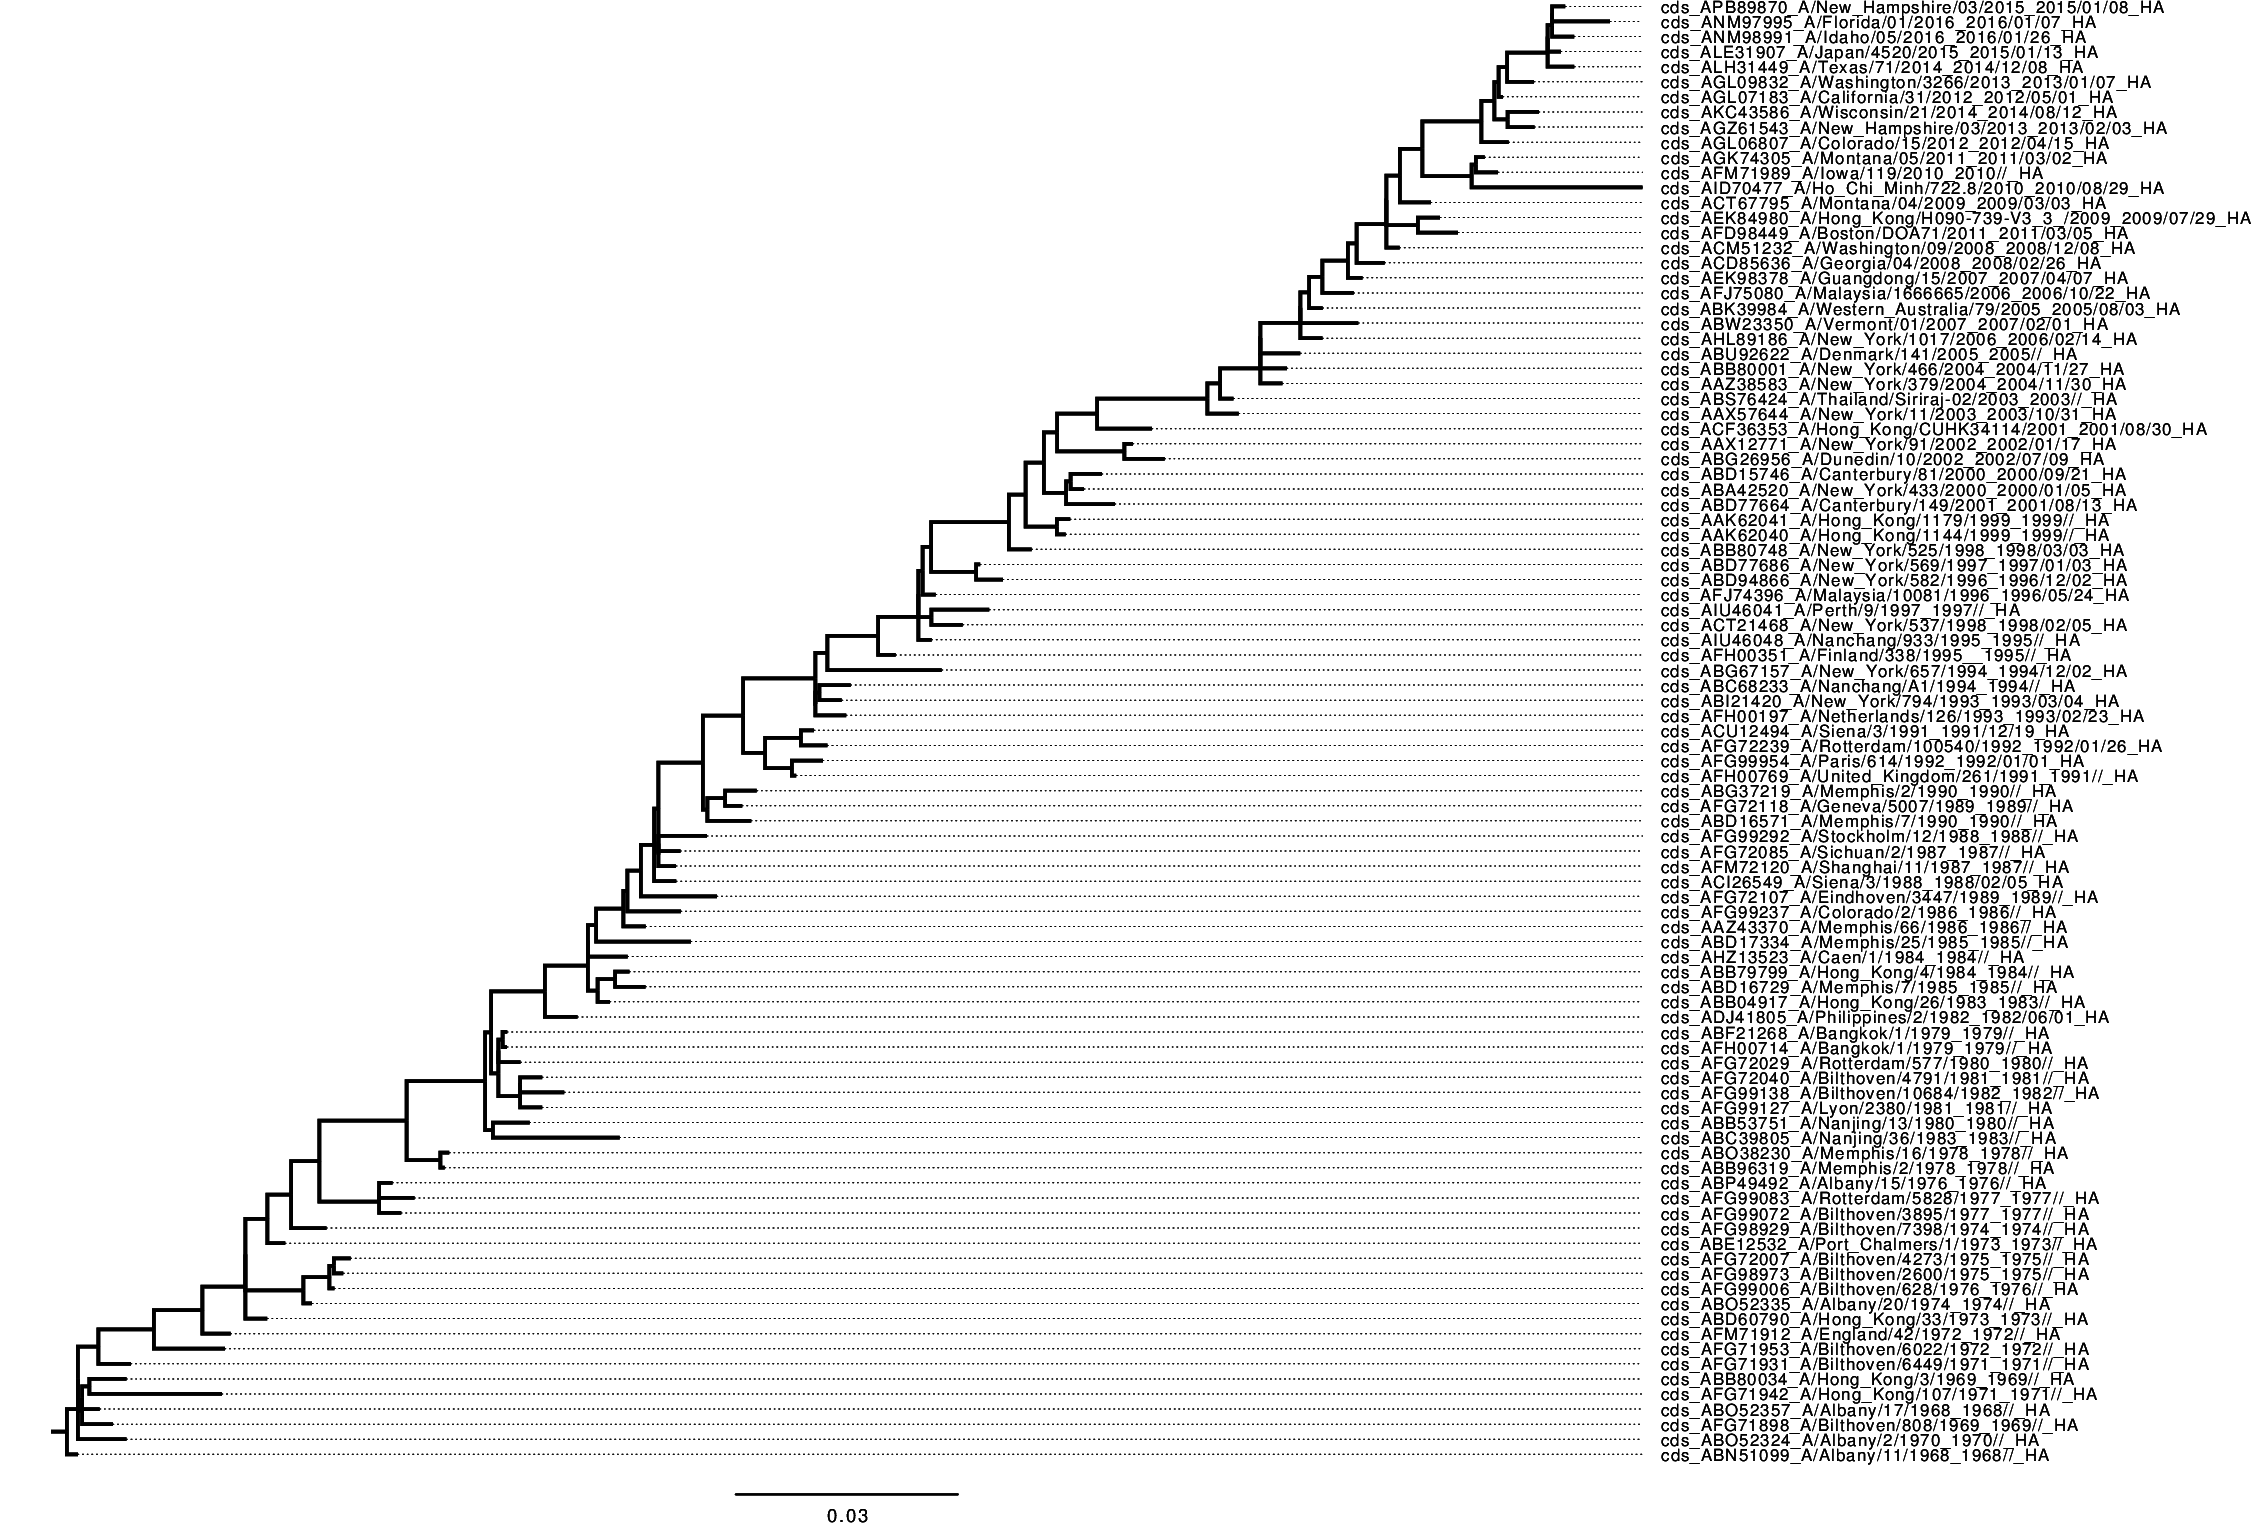

human subsample #2 tree


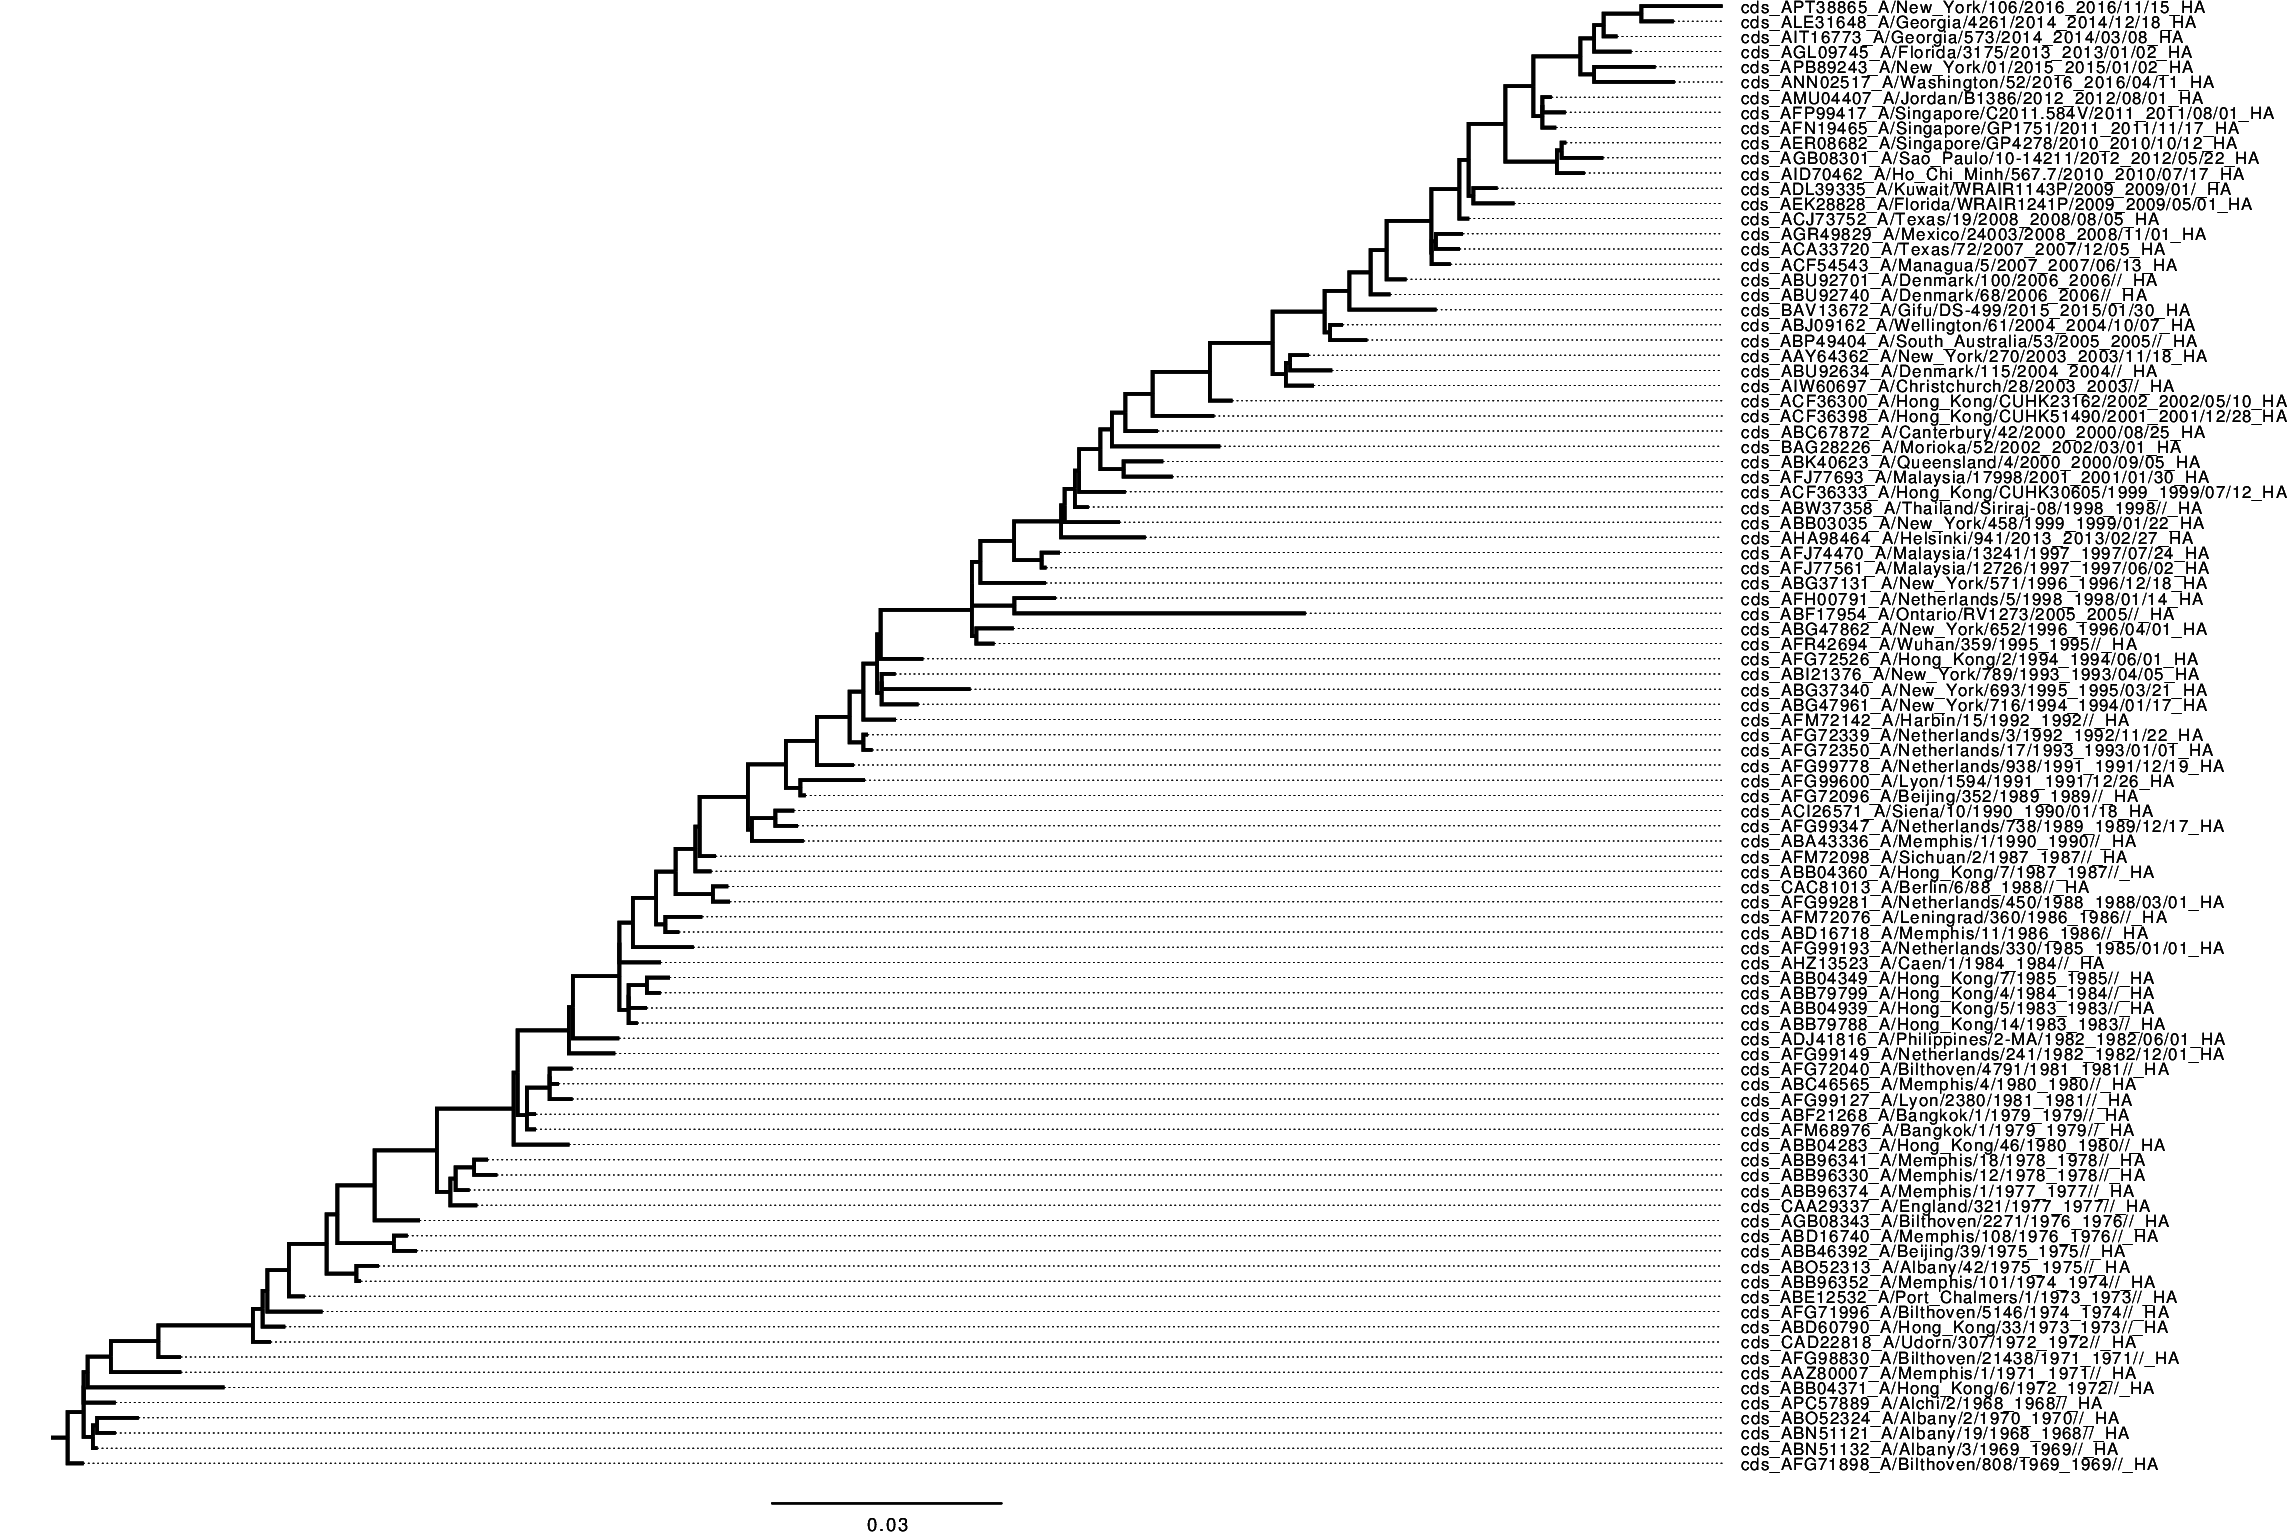

human subsample #3 tree


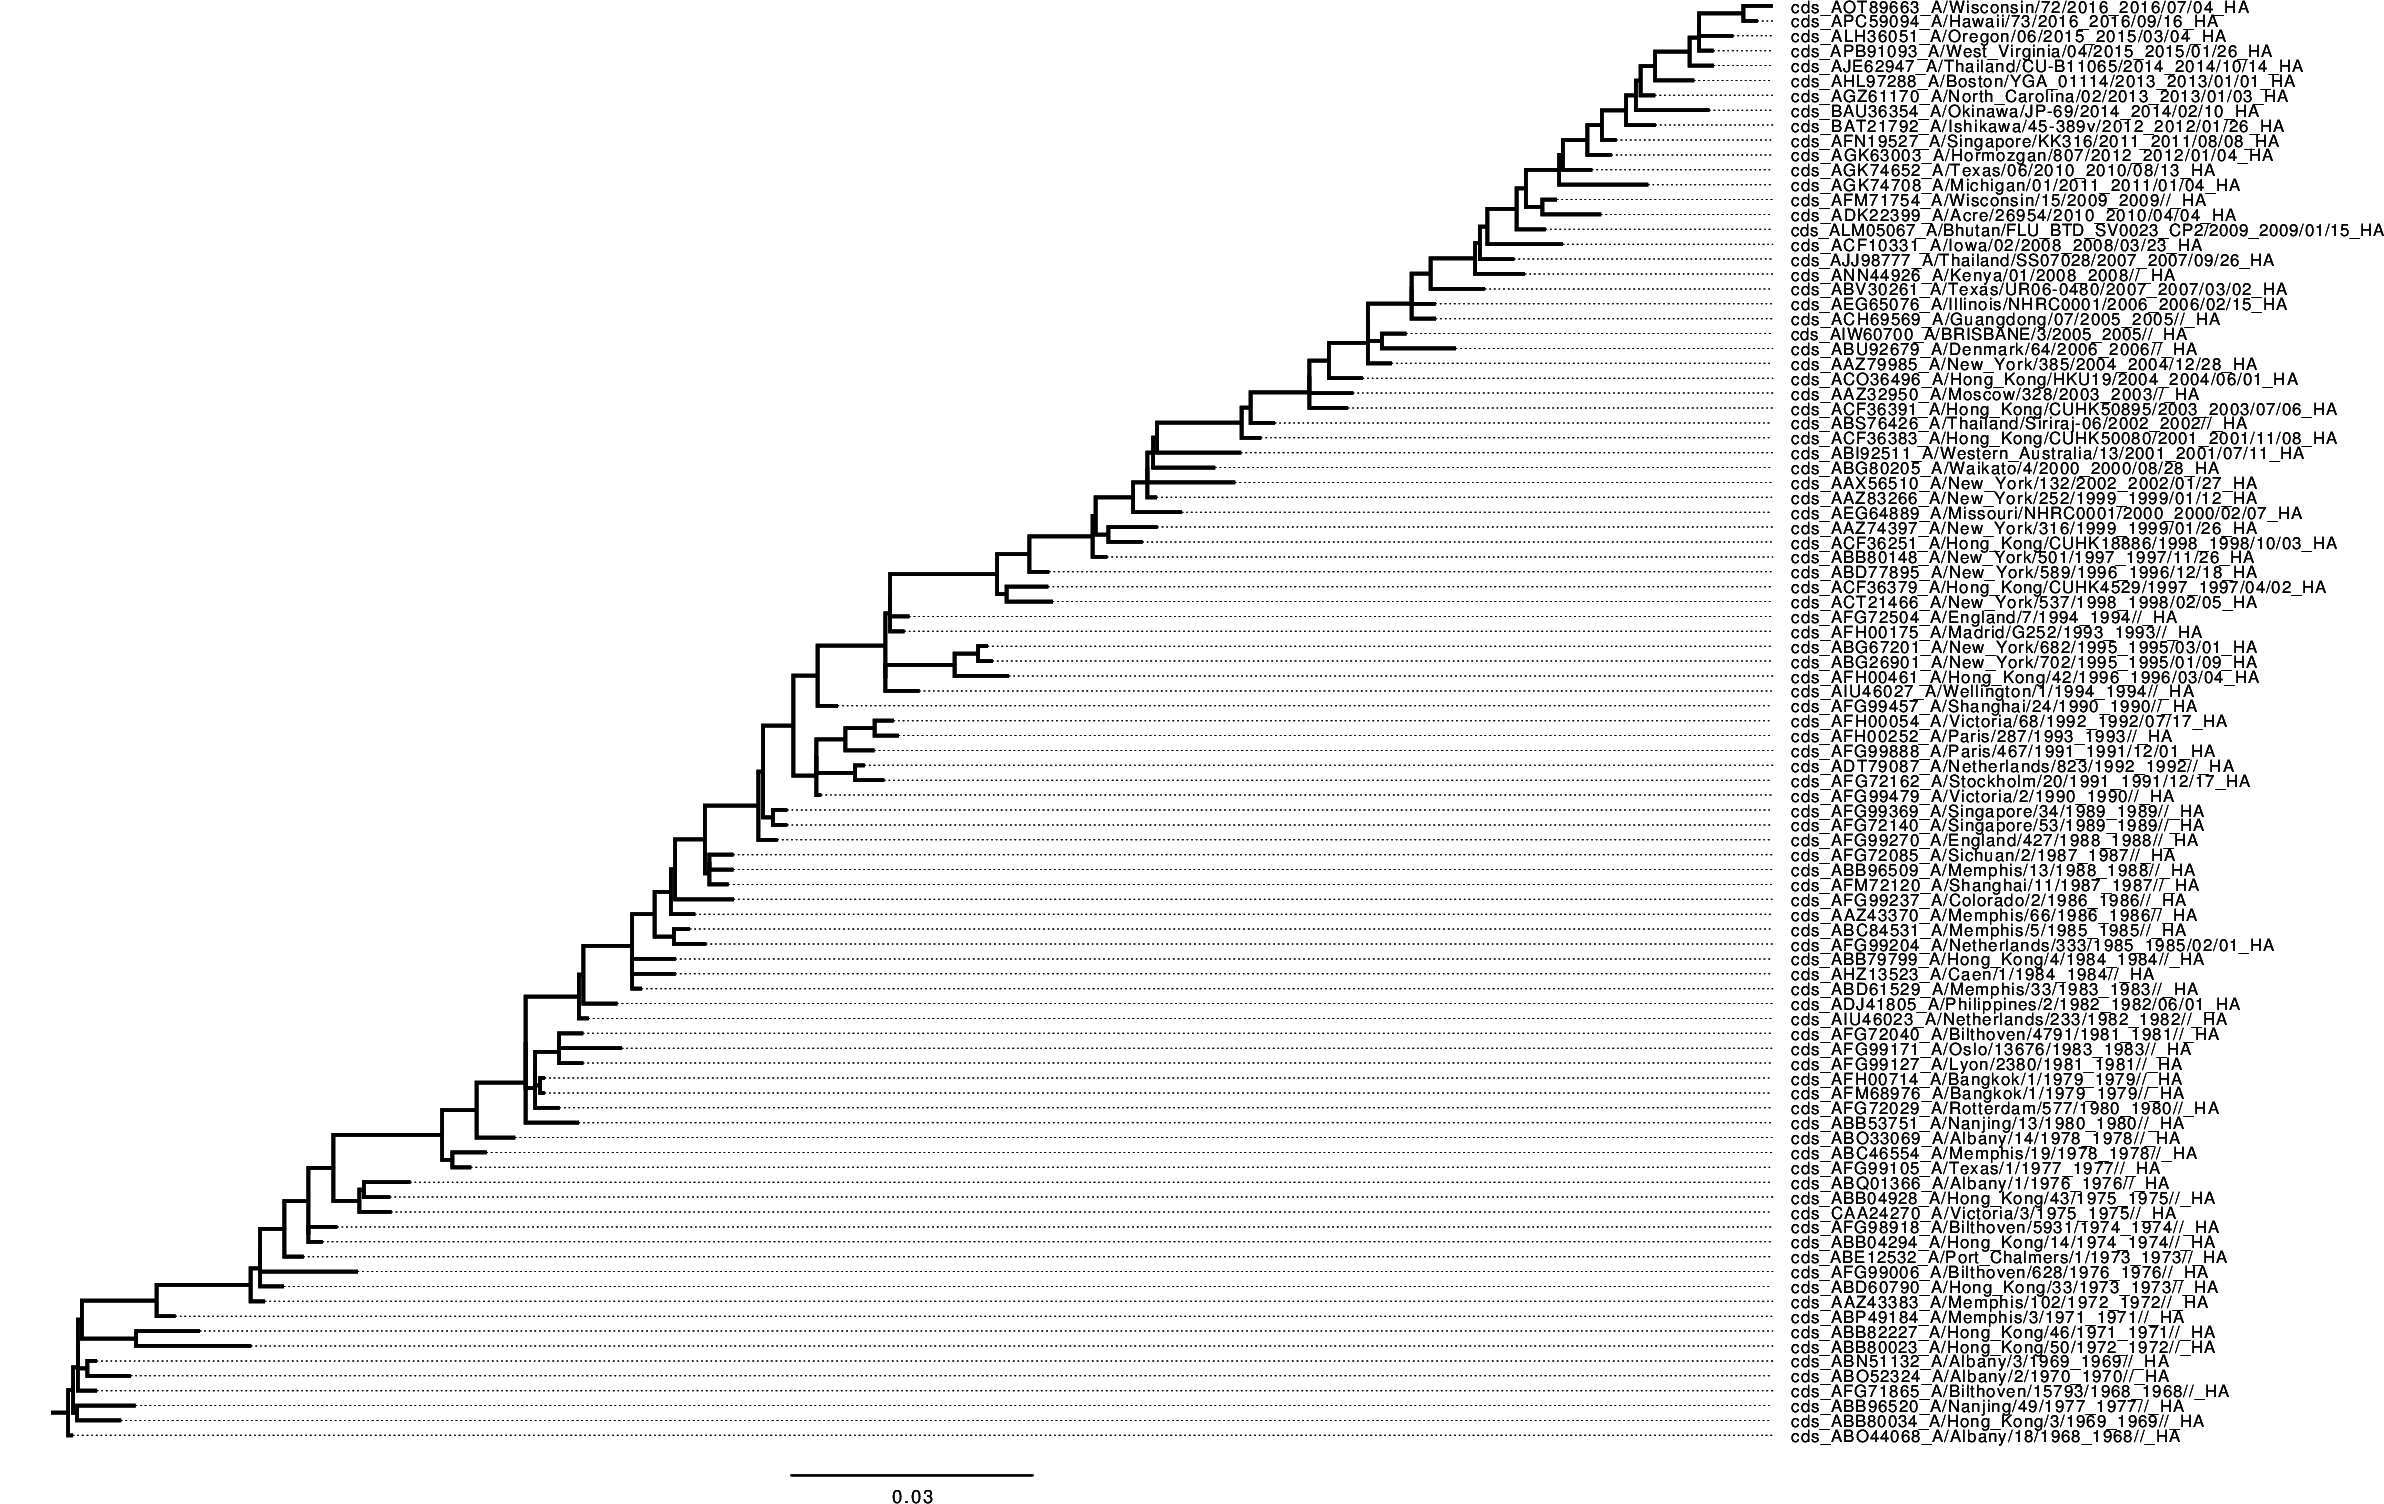

Here are the RAxML trees for subsampled H3 HA from swine hosts:

swine subsample #1 tree


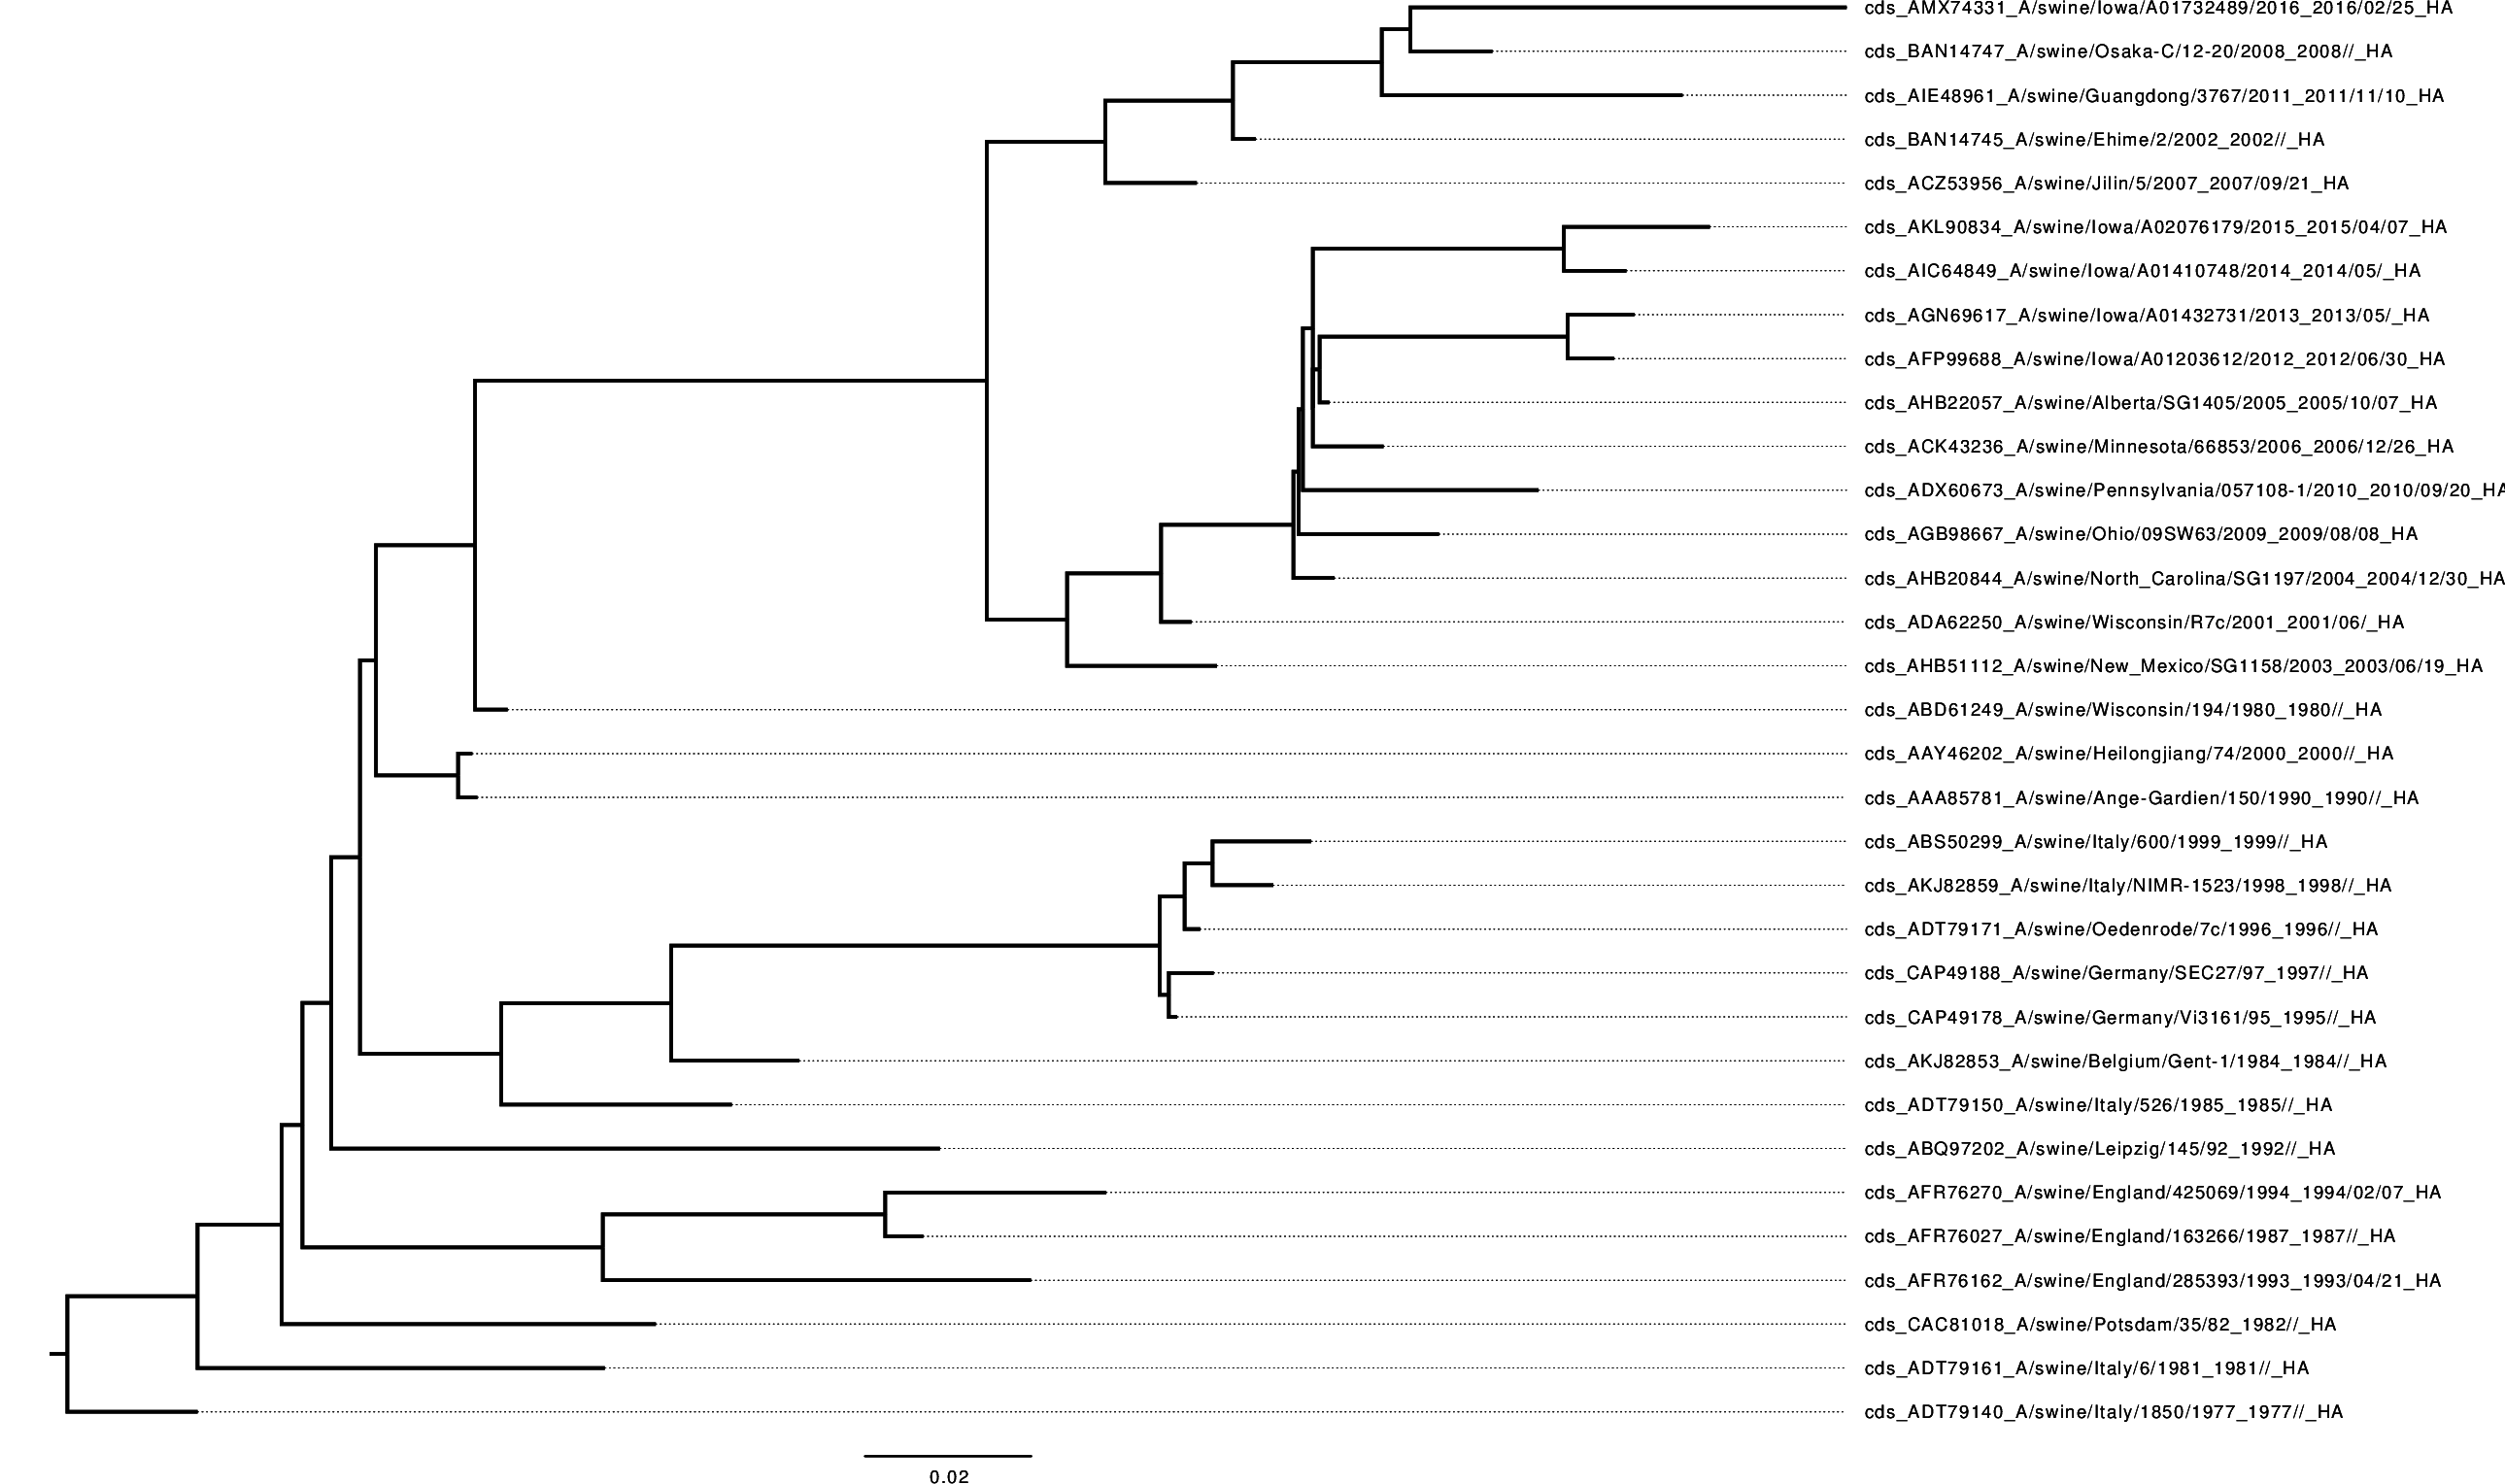

swine subsample #2 tree


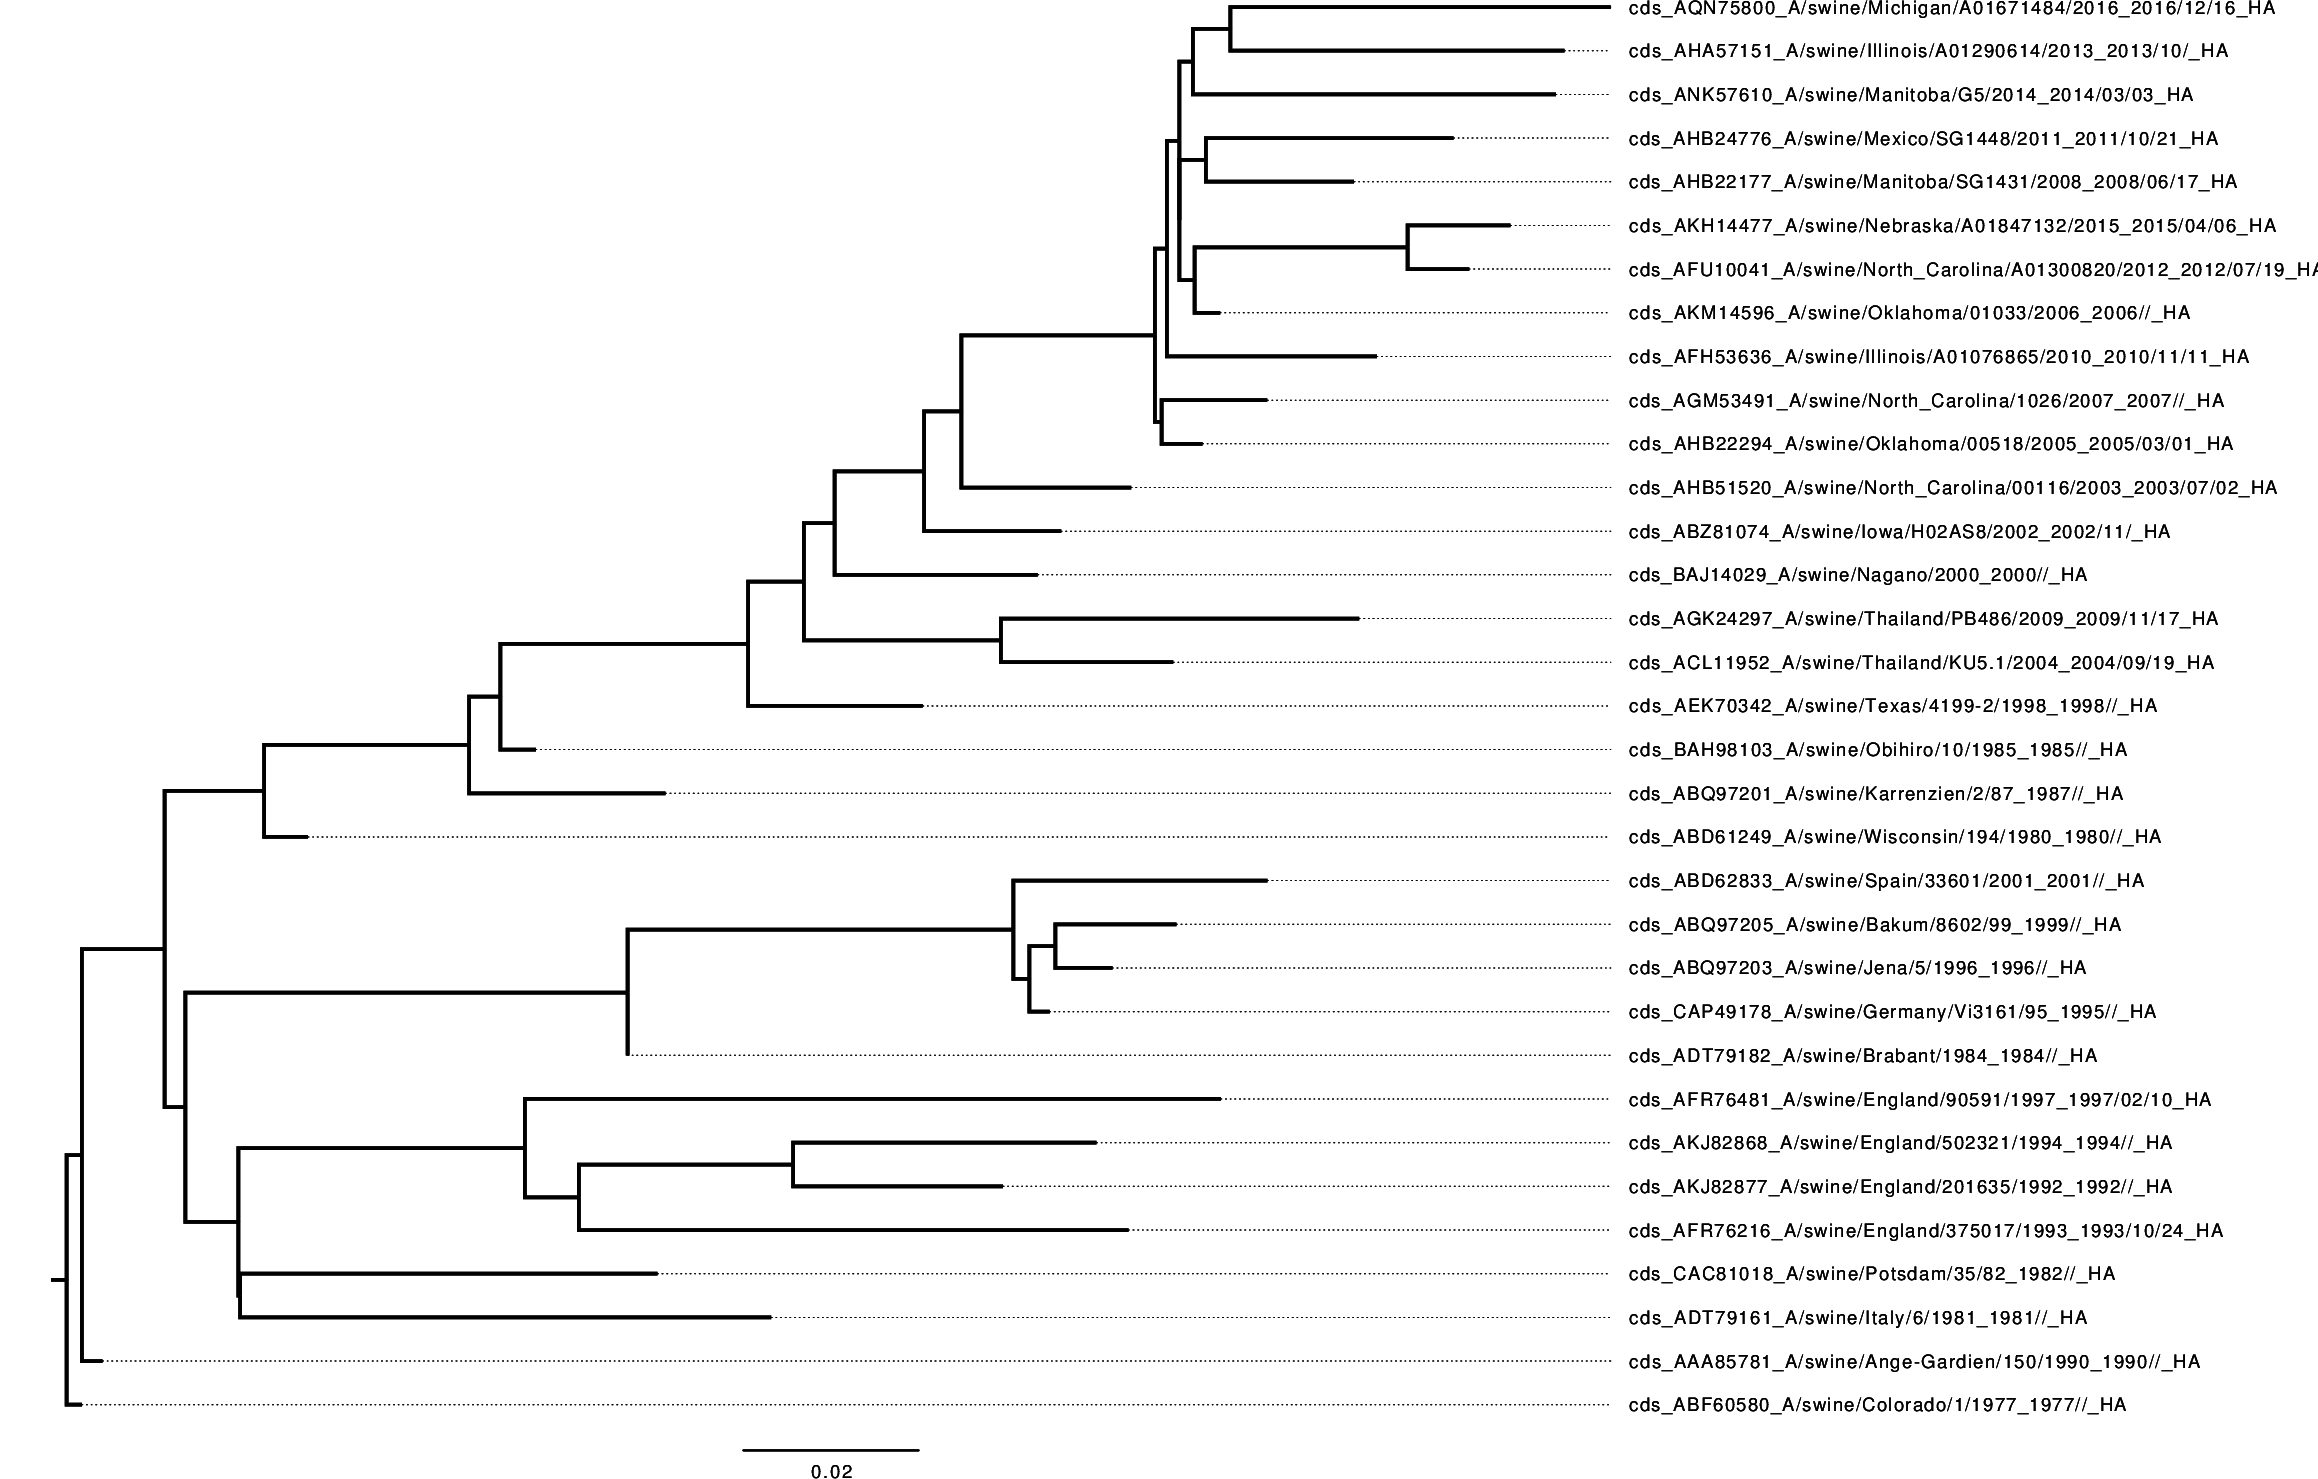

swine subsample #3 tree


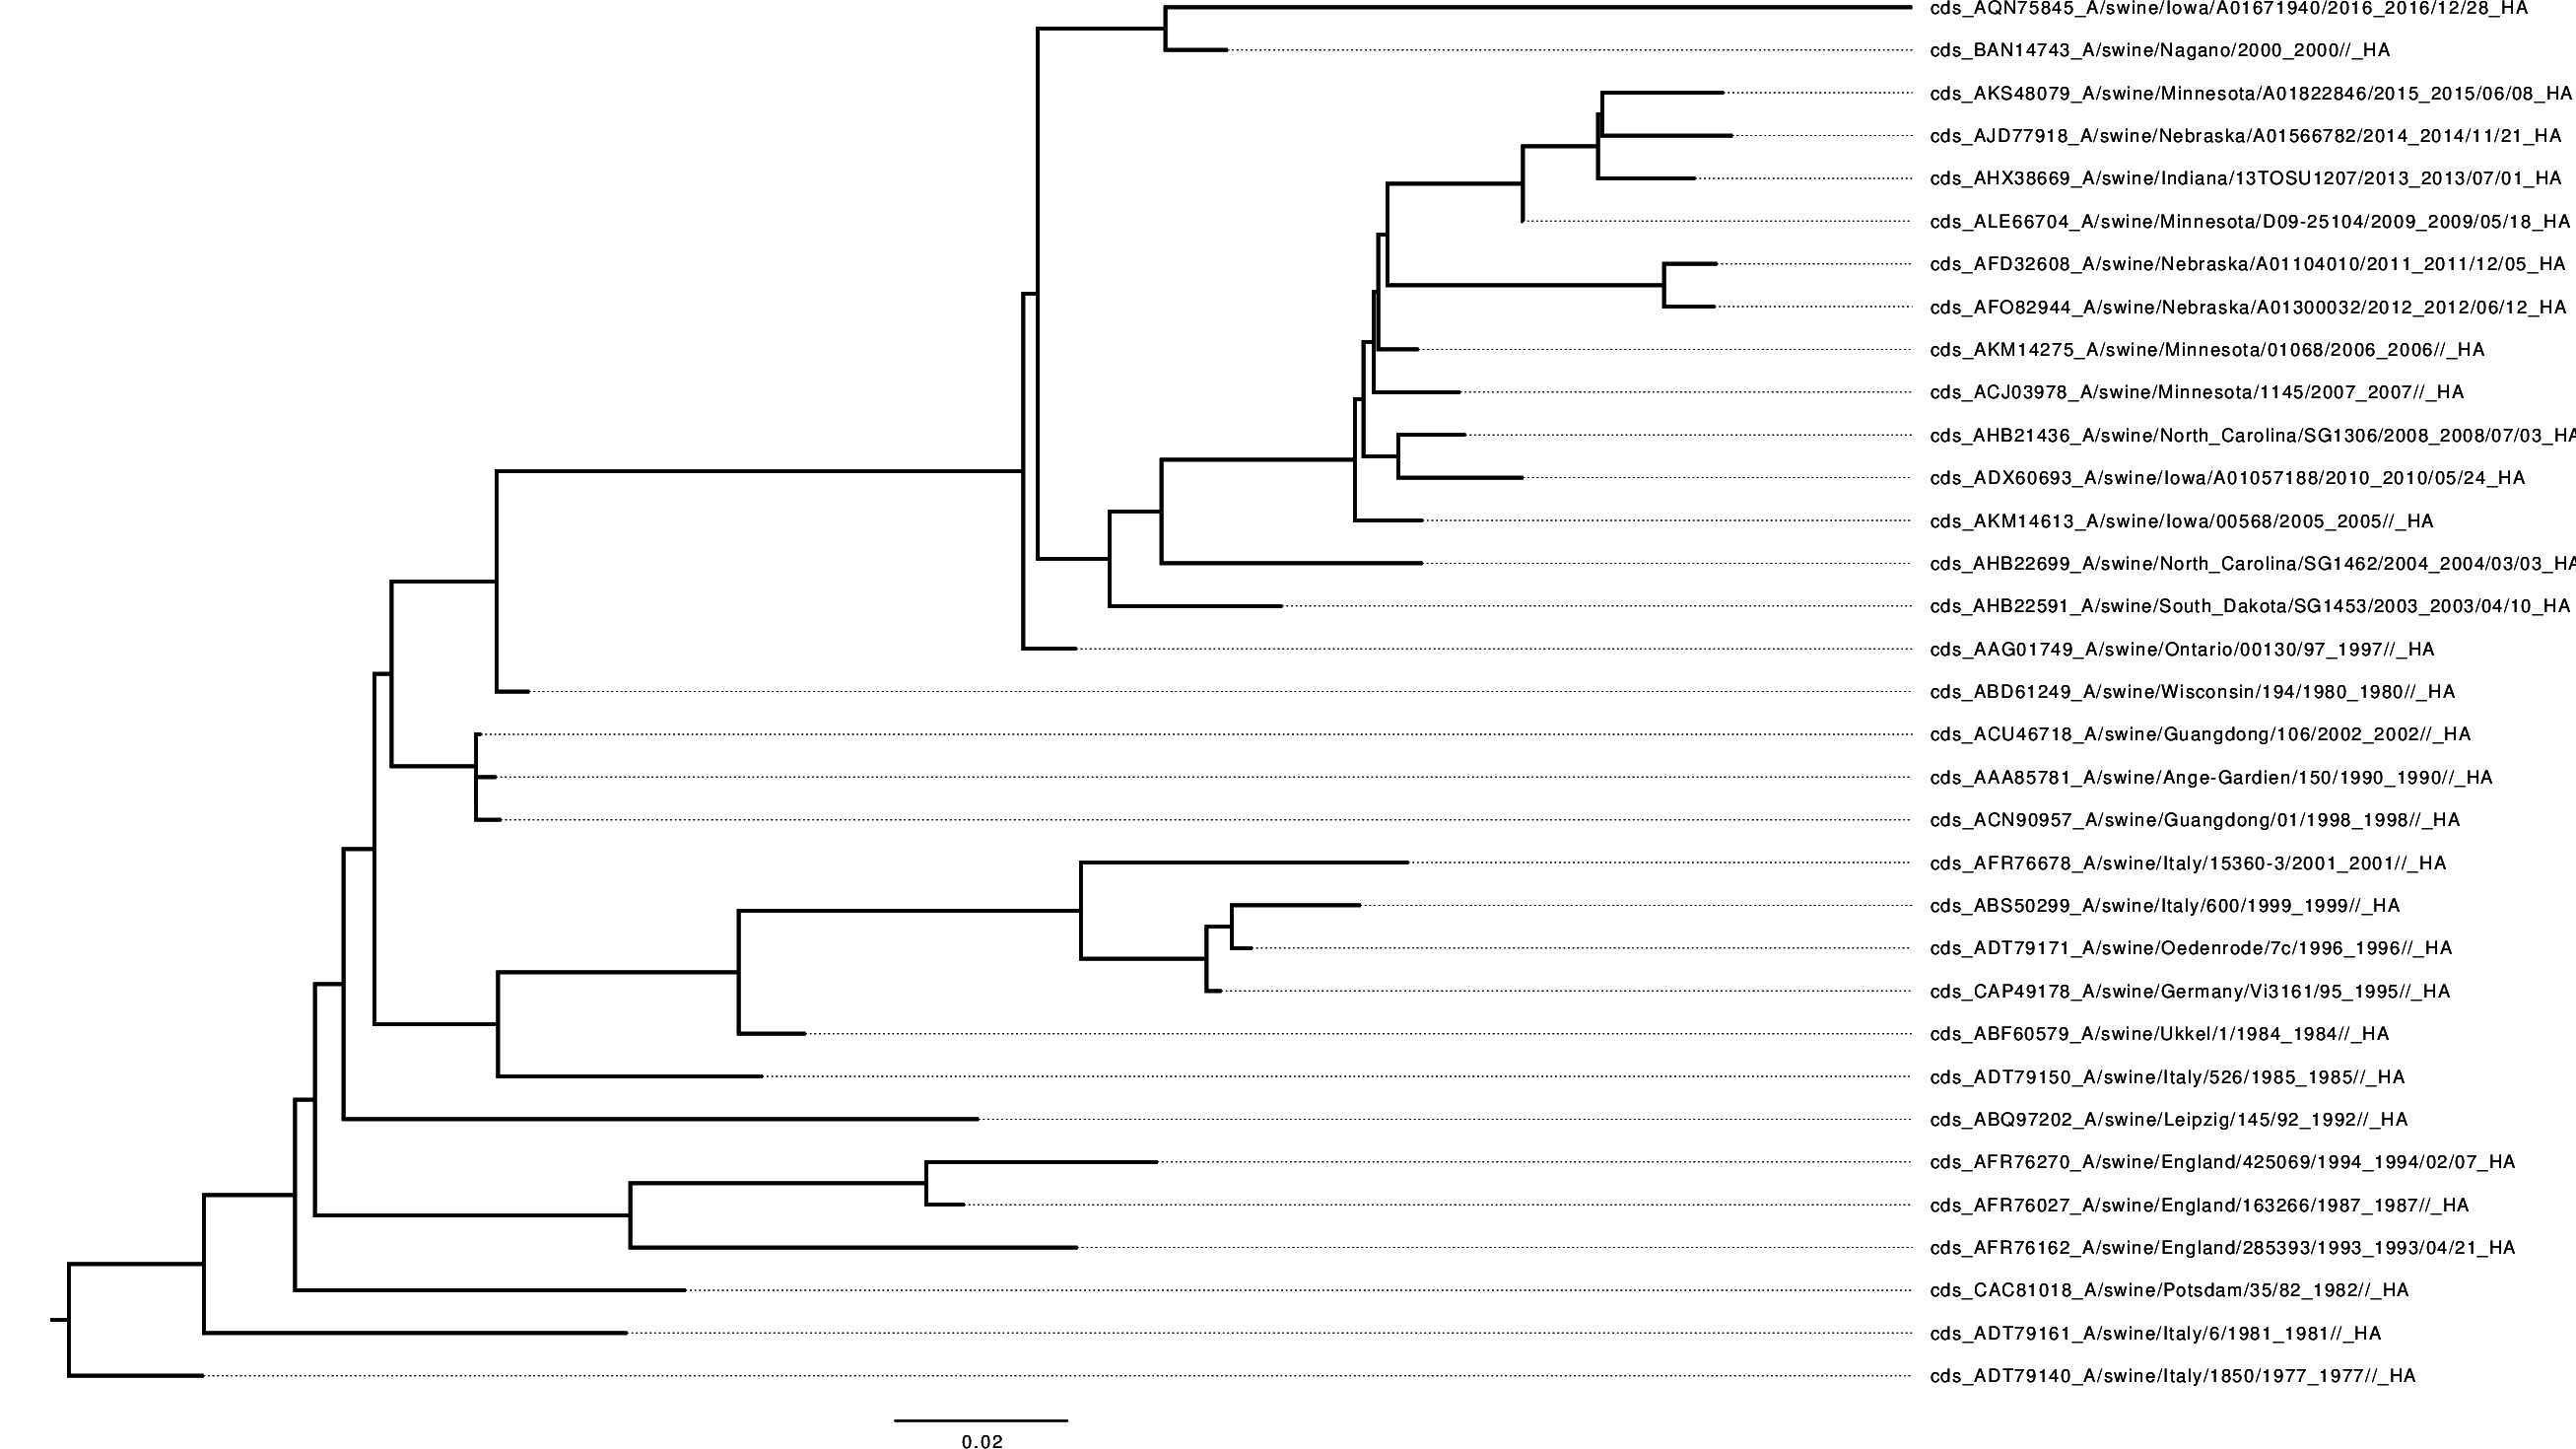

In [19]:
treesdir = '{0}/trees/'.format(resultsdir)
if not os.path.isdir(treesdir):
    os.mkdir(treesdir)

hosts = ['human', 'swine']

for host in hosts:
    print ('Here are the RAxML trees for subsampled H3 HA from {0} hosts:\n'.format(host))
    for sample in [1, 2, 3]:
        print ('{0} subsample #{1} tree'.format(host, sample))
        showPDF('{0}/H3_{1}_{2}_RAxML_tree.pdf'.format(treesdir, host, sample))

## Run `phydms_comprehensive` using averaged preferences and subsampled human H3 sequences

I will now run `phydms_comprehensive` using the following inputs:

1. **Preferences**: Averaged preferences without stop codons
  * Preferences averaged across all replicates (rep. 1, 2, 3-1, 3-2)
  * Preferences averaged across replicates 2, 3-1, and 3-2  
2. **Alignments**: the three subsampled sequences created by using `subsample_IVR_sequences.py` above
  * Three subsampled alignments using one sequence per year
  * Three subsampled alignments using two sequences per year

In [20]:
raxml_path = 'raxmlHPC-SSE3'

phydmsdir = '{0}/H3_phydms/'.format(resultsdir)

if os.path.isdir(phydmsdir):
    print ('Output of phydms_comprehensive already exists.')
else:
    print('Running phydms_comprehensive...')    
    for sample in [1, 2, 3]:
        subprocess.check_call(['phydms_comprehensive', '{0}H3_{1}'.format(phydmsdir, sample), 
                               '{0}_{1}.fa'.format(subsample_TwoPerYear_outPrefix, sample), 
                               avgprefs, 
                               '--raxml', raxml_path, '--ncpus', '-1', '--omegabysite'])

Output of phydms_comprehensive already exists.


Here is the model comparison pasted from the **H3_3** subsample (using two sequences per year).

| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -8439.33      | 6       | beta=2.44, kappa=5.78, omega=0.91             |
| YNGKP_M5                        | 2166.06  | -9516.36      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_summary_avgprefs | 2504.18  | -9691.42      | 6       | beta=0.68, kappa=5.58, omega=0.32             |
| YNGKP_M0                        | 2607.92  | -9738.29      | 11      | kappa=5.05, omega=0.31                        |

# See how well the site-specific amino acid preferences inferred above describe natural sequence evolution of swine H3 HA using `phydms`

## Prepare input H3 fasta files using `phydms_prepalignment`

I downloaded the `H3_swine.fa` file from all full-length, protein-coding **swine** H3 sequences from the Influenza Virus Resource Database on 20170419. (Sequences exist from 1977 to 2017)

In [31]:
swineIVRfile = 'H3_swine.fa'

swine_infile = '{0}/{1}'.format(inputdir, swineIVRfile)
swine_outfile = '{0}/H3_swine_ref.fa'.format(inputdir)

if os.path.isfile(swine_outfile):
    print('Perth/2009 HA reference sequence already added to swine H3 sequences FASTA file.')
else:
    print('Adding Perth/2009 HA reference sequence to swine H3 sequences FASTA file...')
    os.system('cat {0} {1} > {2}'.format(swine_infile, infile2, swine_outfile))

Perth/2009 HA reference sequence already added to swine H3 sequences FASTA file.


In [32]:
swineIVRalignment = '{0}/H3_swine_alignment.fa'.format(inputdir)

if os.path.isfile(swineIVRalignment):
    print('Swine H3 IVR sequences have already been prepped by phydms_prepalignment.')
else:
    subprocess.check_call(['phydms_prepalignment', '{0}/H3_swine_ref.fa'.format(inputdir), 
                           swineIVRalignment, Perth09header])

Swine H3 IVR sequences have already been prepped by phydms_prepalignment.


Here is the model comparison pasted from the **H3_1 swine** subsample (using one sequence per year).

| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -9042.21      | 6       | beta=2.38, kappa=6.05, omega=0.72             |
| YNGKP_M5                        | 2387.82  | -10230.12     | 12      | alpha_omega=0.35, beta_omega=1.30, kappa=5.26 |
| averaged_ExpCM_summary_avgprefs | 2702.52  | -10393.47     | 6       | beta=0.71, kappa=5.73, omega=0.25             |
| YNGKP_M0                        | 2864.72  | -10469.57     | 11      | kappa=5.12, omega=0.24                        |

The log likelihood of the ExpCM suggests that the preferences are able to improve descriptions of the evolution of both human and swine H3 HA in nature.

## Subsample the aligned and filtered swine H3 sequences using `subsample_IVR_sequences.py`

I will subsample the aligned and filtered swine H3 sequences in `H3_swine_alignment.fa`, using at most **1 sequence per year**. I will create 3 independent alignments.

The script I will use is `subsample_swine_H3.py`, which I modified from Sarah's `subsample_IVR_sequences.py` script.
These output files will be named with the prefix `H3_swine_`.

In [33]:
swine_subsample_outPrefix = '{0}/H3_swine_subsample'.format(inputdir)

for sample in [1, 2, 3]:
    if os.path.isfile('{0}_{1}.fa'.format(swine_subsample_outPrefix, sample)):
        print ('Subsampled swine alignment #{0} already exists'.format(sample))
    else:
        os.system('python scripts/subsample_swine_H3.py {0} 3 {1}'.format(swineIVRalignment, swine_subsample_outPrefix))

Subsampled swine alignment #1 already exists
Subsampled swine alignment #2 already exists
Subsampled swine alignment #3 already exists


## Run `phydms_comprehensive` using averaged preferences and subsampled swine H3 sequences

I will now run `phydms_comprehensive` using the following inputs:

1. **Preferences**: Averaged preferences without stop codons
  * Preferences averaged across all replicates (rep. 1, 2, 3-1, 3-2)
  * Preferences averaged across replicates 2, 3-1, and 3-2  
2. **Alignments**: the three subsampled swine sequences created by using `subsample_swine_H3.py` above

In [34]:
swinephydmsdir = '{0}/H3_swine_phydms/'.format(resultsdir)

if os.path.isdir(swinephydmsdir):
    print ('Output of swine phydms_comprehensive already exists.')
else:
    for sample in [1, 2, 3]:
        subprocess.check_call(['phydms_comprehensive', '{0}H3_{1}'.format(swinephydmsdir, sample), 
                               '{0}_{1}.fa'.format(swine_subsample_outPrefix, sample), 
                               avgprefs, 
                               '--raxml', raxml_path, '--ncpus', '-1', '--omegabysite'])

Output of swine phydms_comprehensive already exists.


## Make logoplots of merged preferences 

I will use the rescaling parameter ( $\beta$ ) from `phydms_comprehensive` to create logoplots of rescaled preferences.
First, I will read in the beta values from the `ExpCM *_modelparams.txt` files (I will use the subsampled alignment #3).

In [21]:
params_file = open('{0}/H3_3_ExpCM_summary_avgprefs_modelparams.txt'.format(phydmsdir), 'r')
params_lst = [line.rstrip() for line in params_file.readlines()]
params_file.close()
beta = float([line for line in params_lst if 'beta' in line][0][7:])
print ('The beta parameter for the ExpCM for the averaged preferences = {0}'.format(beta))

The beta parameter for the ExpCM for the averaged preferences = 2.43599


Before making the logoplot, I will also create a new rescaled preferences file.

In [34]:
unscaled_prefsdf = pd.read_csv(avgprefs)
scaled_prefsdf = dms_tools2.prefs.rescalePrefs(unscaled_prefsdf, beta)

rescaledavgprefs = os.path.join(prefsdir, 'summary_avgprefs_rescaled.csv')
scaled_prefsdf.to_csv(rescaledavgprefs, index=False)

Next, I will use the stringency parameters ( $\beta$ ) to make rescaled logoplots by specifying the `'--stringency'` argument.

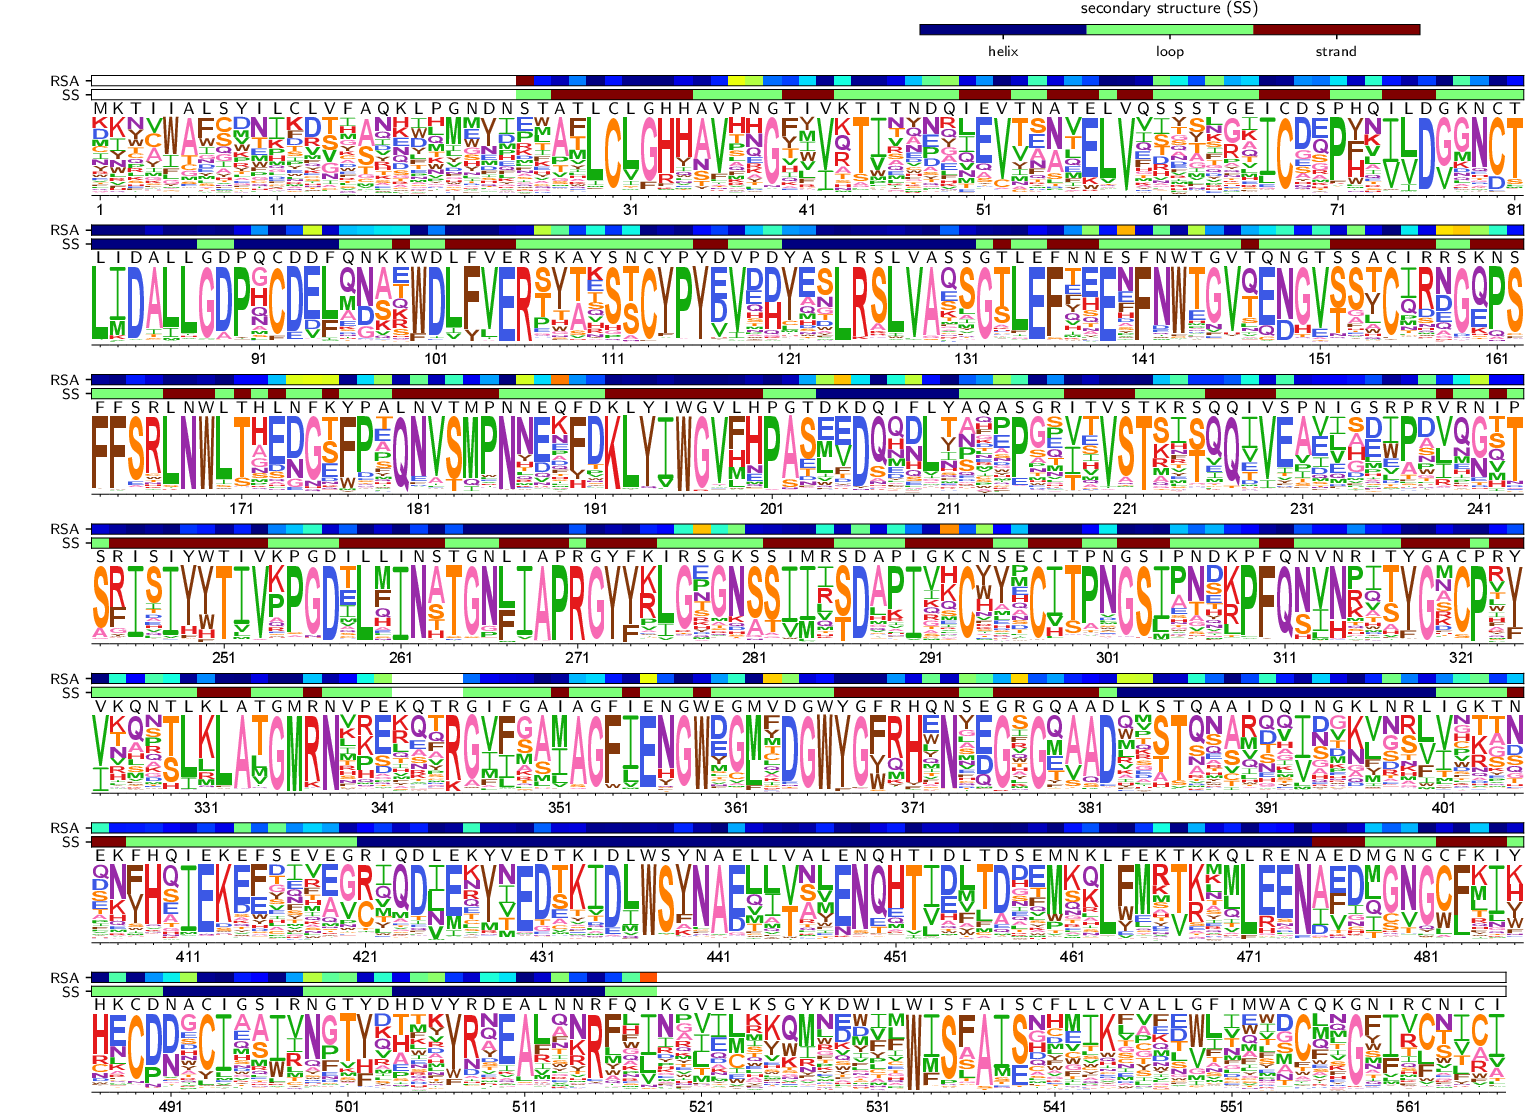

In [36]:
rescaledlogoname = 'rescaled-avgprefs'

log = !dms2_logoplot \
        --prefs {avgprefs} \
        --name {rescaledlogoname} \
        --outdir {logodir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {ssfile} SS "secondary structure" \
        --overlay3 {rsafile} RSA "relative solvent accessibility" \
        --nperline 81 \
        --stringency {beta} \
        --use_existing {use_existing}
        
rescaledlogoplot = os.path.join(logodir, '{0}_prefs.pdf'.format(rescaledlogoname))
showPDF(rescaledlogoplot)

### Logoplot of averaged preferences in H3 numbering

In [37]:
H3num_prefsfile = '{0}/avgprefs_H3numbering.txt'.format(prefsdir)

# if os.path.isfile(H3num_prefsfile):
#     print('Perth/2009 preferences are already renumbered into H3 numbering.')
# else:
#     print('Renumbering preferences into H3 numbering...')
#     subprocess.check_call(['dms_editsites', '{0}/avgprefs_all.txt'.format(prefsdir), 
#                            H3num_prefsfile, 
#                            'renumber', '{0}/H3renumbering_scheme.txt'.format(inputdir)])

## Calculate the site entropy and write to a new preferences file

In [38]:
entropy_prefsdf = dms_tools2.prefs.prefsEntropy(scaled_prefsdf, dms_tools2.AAS)

entropyprefs = os.path.join(prefsdir, 'summary_avgprefs_rescaled_entropies.csv')
entropy_prefsdf.to_csv(entropyprefs, index=False)